In [1]:
%reset
from sympy import init_printing
from tqdm.auto import tqdm
import sympy as sp
import pandas as pd
import random
import string
import traceback
from func_timeout import func_set_timeout, FunctionTimedOut
init_printing()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


**Vocabulary**

In [2]:
symbol = lambda x: sp.Symbol(x, commutative = True)

In [3]:
identifiers = [i for i in list(string.ascii_lowercase + string.ascii_uppercase) if i not in ['i','e','d','O']]

In [4]:
symbols = [symbol(i) for i in identifiers]

In [5]:
unseen_symbols = [symbol(i) for i in ["\\alpha","\\beta","\\gamma","\\delta","\\pi","\\xi","\\chi","\\sigma","\\psi","\\omega"]]

In [6]:
unseen_symbols

**Rules**

In [7]:
def add(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0] + y, x.args[1] + y)
    
    else:
        return x + y

In [8]:
add(symbols[0], symbols[1])

In [9]:
def minus(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0] - y, x.args[1] - y)
    
    else:
        return x - y

In [10]:
def times(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0]*y, x.args[1]*y)
    
    else:
        return x*y

In [11]:
def power(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0]**y, x.args[1]**y)
    
    else:
        return x**y

In [12]:
def divide(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(x.args[0]/y, x.args[1]/y)
    
    else:
        return x/y

In [13]:
def differentiate(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.diff(x.args[0], y, evaluate=False), sp.diff(x.args[1], y, evaluate=False))
    
    else:
        y = random.choice(list(x.free_symbols))
        return sp.diff(x, y, evaluate = False)

In [14]:
def integrate(x, y):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.Integral(x.args[0], y), sp.Integral(x.args[1], y))
    
    else:
        y = random.choice(list(x.free_symbols))
        return sp.Integral(x, y)

In [15]:
def evaluate_integrals(x):
    # assumes derivation D is a global list of equations
    # D_local is a local copy of D which is edited within this function
    # assumes a list of symbols
    # does not integrate terms containing DOUBLE INTEGRALS or higher
    
    if not contains_double_integral(x):
    
        D_local = [i[0] for i in D.copy()]

        used_symbols = []
        for eq in D_local:
            used_symbols.extend(list(eq.free_symbols))

        integral_constants = [i for i in symbols if i not in used_symbols]

        if type(x) == sp.Integral:
            return x.doit() + random.choice(integral_constants)

        elif type(x) == sp.Equality:
            elems = get_equation_elements(x)

            integrals = [i for i in elems if type(i) == sp.Integral]

            subs = [(i, i.doit() + random.choice(integral_constants)) if str(sp.simplify(i)) != str(sp.simplify(i.doit())) else (i, i) for i in integrals]

            for i in subs:
                x = x.subs(i[0], i[1])

            return x

        else:
            return x
        
    else:
        
        return x
    
    # delete elses

In [16]:
def evaluate_derivatives(x):
    
    if type(x) == sp.Derivative:
        return x.doit()
    
    elif type(x) == sp.Equality:
        elems = get_equation_elements(x)
        
        derivatives = [i for i in elems if (type(i) == sp.Derivative) and ('\int' not in sp.latex(i))]
        
        subs = [(i, i.doit()) for i in derivatives]
        
        for i in subs:
            x = x.subs(i[0], i[1])
            
        return x
    
    else:
        return x

In [17]:
def cos(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.cos(x.args[0]), sp.cos(x.args[1]))
    
    else:
        return sp.cos(x)

In [18]:
def sin(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.sin(x.args[0]), sp.sin(x.args[1]))
    
    else:
        return sp.sin(x)

In [19]:
def exp(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.exp(x.args[0]), sp.exp(x.args[1]))
    
    else:
        return sp.exp(x)

In [20]:
def log(x):
    
    if type(x) == sp.Equality:
        return sp.Eq(sp.log(x.args[0]), sp.log(x.args[1]))
    
    else:
        return sp.log(x)

In [21]:
def expand(x):
    return sp.expand(x)

In [22]:
def substitute_LHS_for_RHS(eq_1, eq_2):
    return eq_1.subs(eq_2.args[0], eq_2.args[1])

In [23]:
def substitute_RHS_for_LHS(eq_1, eq_2):
    return eq_1.subs(eq_2.args[1], eq_2.args[0])

In [24]:
def get_premise(symbols):
    
    rules_1 = [cos, sin, exp, log]
    rules_2 = [add, minus, times, power, divide, differentiate, integrate]
    
    arity = random.choice([1,2])

    if arity == 1:
        rule = random.choice(rules_1)
        sym = random.choice(symbols)
        RHS = rule(sym)
        LHS = random.choice([i for i in symbols if i != sym])

    elif arity == 2:
        rule = random.choice([i for i in rules_2 if i not in [differentiate, integrate]])
        sym_1 = random.choice(symbols)
        sym_2 = random.choice([i for i in symbols if i != sym_1])
        RHS = rule(sym_1, sym_2)
        LHS = random.choice([i for i in symbols if i not in [sym_1, sym_2]])
        

    # make RHS more complex
    complexity = random.choice(range(2))

    for i in range(complexity):
        
        arity = random.choice([1,2])
        
        if arity == 1:
            rule = random.choice(rules_1)
            RHS = rule(RHS)
            
        elif arity == 2:
            rule = random.choice(rules_2)
            sym = random.choice(symbols)
            
            RHS = rule(RHS, sym)
            
    LHS = sp.Function(LHS)(*tuple(RHS.free_symbols))

    eq = sp.Eq(LHS, RHS)
    
    return eq

In [25]:
def renaming_premise(symbols):
    
    while True:
        elems = []
        for eq, _ in D:
            elems.extend(get_equation_elements(eq))

        elems = list(dict.fromkeys(elems))

        # more than one free symbol in RHS
        elems = [i for i in elems if len(list(i.free_symbols)) > 0 and len(str(i)) > 1]

        RHS = random.choice(elems)

        LHS = sp.Function(random.choice([i for i in symbols if i not in RHS.free_symbols]))(*tuple(RHS.free_symbols))
        
        if len(str(type(RHS))) > 1 and str(LHS) not in str(D):
            break

    return sp.Eq(LHS, RHS)

In [26]:
def get_equation_elements(eq):

    args = list(eq.args)

    while True:

        old_length = len(args)

        for i in args:
            args.extend(i.args)

        args = list(dict.fromkeys(args))

        new_length = len(args)

        if new_length == old_length:
            break
            
    return [i for i in args if type(i) != sp.Tuple]

In [27]:
contains_double_integral = lambda eq: True if True in ['iint' in sp.latex(i) for i in get_equation_elements(eq)] else False

In [28]:
def pref_eqs(D, p):
    # makes the last equation p times more likely
    # equation n-i is p-i times more likely

    out = []

    new_D = D.copy()[-p:]
    new_D.reverse()
    for i in range(len(new_D)):
        if p-1 > i:
            out.extend([new_D[i]]*(p-i-1)**3)
        
    out.reverse()
    return D + out

In [29]:
def valid_substitutions(rule_name, D):

    sub_options = []
    
    for i in D:
        for j in D:
            if str(i) != str(j):
                LHS, RHS = j.args
                
                if (type(LHS) is not sp.numbers.One) and (type(LHS) is not sp.numbers.Zero) and (type(RHS) is not sp.numbers.Zero) and (type(RHS) is not sp.numbers.One):
                
                    if rule_name == "substitute_LHS_for_RHS":

                        if (str(LHS) in str(i)) and (type(i.subs(LHS, RHS)) is sp.Equality) and (i.subs(LHS, RHS) != i):

                            pair = [D.index(i), D.index(j)]
                            sub_options.append(pair) if pair not in sub_options else 0

                    elif rule_name == "substitute_RHS_for_LHS":

                        if (str(RHS) in str(i)) and (type(i.subs(RHS, LHS)) is sp.Equality) and (i.subs(RHS, LHS) != i):

                            pair = [D.index(i), D.index(j)]
                            sub_options.append(pair) if (pair not in sub_options) and (pair[0] != pair[1]) else 0
                    
    return sub_options

In [30]:
@func_set_timeout(5)
def step(D, p_history=10, p_arity_0=5, p_renaming=100, p_arity_1=50, p_evaluate=50, p_arity_2=100, p_int_or_diff=2, p_subs=30):
    
    
    # p_history: equation n-i is p-i times more likely (prioritises more recent equations like memory)
    # p_arity_0: overall probability multiplier for arity 0 functions
    # p_renaming: relevant prob multiplier for renaming premises
    # p_arity_1: overall probability multiplier for arity 1 functions
    # p_evaluate: relative probabilty of int or diff evaluations is multiplied by p_evaluate for arity 1 functions
    # p_arity_2: overall probability multiplier for arity 2 functions
    # p_int_or_diff: relative probability multiplier for int or diff compared to other arity 2 functions without multipliers
    # p_subs: same as p_int_or_diff but for substitution functions
    
    A = [i[1] for i in D] # only annotations
    D = [i[0] for i in D] # only equations
    
    rules_0 = [
        
        get_premise


    ] + [renaming_premise]*p_renaming
    

    rules_1 = [
        
        cos,
        sin,
        exp,
        log,
        expand
        
    ] + [evaluate_derivatives, evaluate_integrals]*p_evaluate
    
    
    rules_2 = [
        
        add,
        minus,
        times,
        divide,
        power
    
    ] + [differentiate, integrate]*p_int_or_diff + [substitute_LHS_for_RHS, substitute_RHS_for_LHS]*p_subs


    # assumes D has at least one equation so far
    relevant_equation_elements = []

    for eq in D:
        relevant_equation_elements.extend(get_equation_elements(eq))
    relevant_equation_elements = list(dict.fromkeys(relevant_equation_elements))

    arity = random.choice([0]*p_arity_0 + [1]*p_arity_1 +[2]*p_arity_2)
    
    elem_1 = 0
    
    if arity == 0:
        rule = random.choice(rules_0)
        eq = rule(symbols)
        annotation = rule.__name__

    if arity == 1:
        rule = random.choice(rules_1)

        # elem_1 can be equation
        elem_1 = random.choice(pref_eqs(D, p_history))
        eq = rule(elem_1)
                
        n = D.index(elem_1)
                
        annotation = [rule.__name__, n+1]
                

    if arity == 2:
        
        # no substitution rules if only 1 equation in D
        if len(D) == 1:
            
            rule = random.choice([i for i in rules_2 if 'subs' not in str(i.__name__)])
        else:
            
            rule = random.choice(rules_2)
        
        # substitution
        if ("subs" in rule.__name__):
            
            # alex says empty lists are falsey, a list with anything in is truthy,
            # so we only need `if valid_substitutions(rule.__name__, D)@`
            if valid_substitutions(rule.__name__, D) != []:
                

                n_1, n_2 = random.choice(valid_substitutions(rule.__name__, D))

                elem_1, elem_2 = D[n_1], D[n_2]
                
                annotation = [rule.__name__, n_1+1, n_2+1]
            
        
        # integration or differentiation
        elif rule.__name__ in ['integrate', 'differentiate']:
            
            # elem_1 can be an equation
            elem_1 = random.choice(pref_eqs(D, p_history))

            # elem_2 can be an equation with components in elem_1
            elem_2 = random.choice([i for i in get_equation_elements(elem_1) if len(str(i)) == 1 and str(i) not in string.digits])
            
            n = D.index(elem_1)
                    
            annotation = [rule.__name__, n+1, elem_2]
            
        
        # integration or differentiation
        elif rule.__name__ in ['power']:
            
            # elem_1 can be an equation
            elem_1 = random.choice(pref_eqs(D, p_history))

            # elem_2 can be an equation with components in elem_1
            elem_2 = random.choice([i for i in get_equation_elements(elem_1) if len(str(i)) < 3])
            
            n = D.index(elem_1)
                    
            annotation = [rule.__name__, n+1, elem_2]
            

        else:

            # elem_1 can be an equation
            elem_1 = random.choice(pref_eqs(D, p_history))

            # elem_2 can be an equation element
            elem_2 = random.choice([i for i in relevant_equation_elements if str(i) not in string.digits])
            
            n = D.index(elem_1)
                    
            annotation = [rule.__name__, n+1, elem_2]

        eq = rule(elem_1, elem_2)
        

    if type(eq) == sp.Equality:
            
        swapped_eq = sp.Eq(eq.args[1], eq.args[0])

        if (eq in D) or ('Subs' in str(eq)) or ('Piecewise' in str(eq)) or (swapped_eq in D) or len(sp.latex(eq)) >= 350:
            return False

        # success
        else:
            return (eq, annotation)

    else:
        return False

In [31]:
# # def foo(predicate):
# #     # elem_1 can be an equation
# #     elem_1 = random.choice(pref_eqs(D, p_history))

# #     # elem_2 can be an equation with components in elem_1
# #     elem_2 = random.choice([i for i in get_equation_elements(elem_1) if predicate(i)])

# #     n = D.index(elem_1)

# #     annotation = [rule.__name__, n+1, elem_2]

# #     eq = rule(elem_1, elem_2)

# #     return eq, annotation

# # integration or differentiation


# elif rule.__name__ in ['integrate', 'differentiate']:

#     eq, annotation = foo(lambda i: len(str(i)) == 1 and str(i) not in string.digits)


# # integration or differentiation
# elif rule.__name__ in ['power']:

#     eq, annotation = foo(lambda i: len(str(i)) < 3)

# else:

#     eq, annotation = foo(lambda i: str(i) not in string.digits)

In [32]:
# for j in range(len(D)):
#     print(j+1)
#     eq, annotation = D[j]
    
#     if type(annotation) == tuple:
#         for i in annotation:
#             display(i)
#     else:
#         print(annotation)
    
#     print('\n')
#     display(eq)
    
#     print('--------------------------------------------------------------------------------------------')

**Use annotations to only include relevant steps in a derivation**

In [33]:
def extract_chain_starting_from_i(i, eq_pairs):
    # eq_pairs is a reverse chronological list of current equation numbers,
    # and the past equation numbers used to make them 
    # e.g., [30, 28], [29, 14], [28, 23, 2]
    
    chain = [eq_pairs[i]]


    while True:

        current_eq = chain[-1][0]
        used_eq = chain[-1][1]

        for pair in eq_pairs:

            last_eq = pair[0]
            if last_eq == used_eq:
                chain.append(pair)

        if (len(chain[-1]) == 1):
            #if pair not in chain: chain.append(pair)
            chain.append(pair) if pair not in chain else 0
            break

    chain_nums = []
    for i in chain:
        chain_nums.extend(i)

    valid_chain = [i for i in chain if len(i) == 1 and i[0] in chain_nums] + chain

    chain = [i for i in chain if i in valid_chain]

    return chain

In [34]:
def merge_chains(chain, eq_pairs):
    
    # finds all chains which come from separate derivations that are substituted in
    # merges any new equations reverse chronologically
    
#     old_chain = None
#     while old_chain != chain:

    while True:
    
        old_chain = chain.copy()

        first_numbers = [i[0] for i in chain]

        # unaccounted for eqs
        missing_eqs = [i[2] for i in chain if len(i) > 2] + [i[1] for i in chain if len(i) > 1 and i[1] not in first_numbers]

        for i in eq_pairs:
            chain.append(i) if (i[0] in missing_eqs) and i not in chain else 0

        if old_chain == chain:
            break

    chain_dict = {i[0]:i for i in chain}

    return sorted(chain)

In [35]:
is_subset = lambda chain_1, chain_2: [i for i in chain_1 if i not in chain_2] == [] if chain_1 != chain_2 else False

In [36]:
def extract_derivations(D):
    
    A = [[i+1] + list(D[i][1]) if type(D[i][1]) is list else [i+1, D[i][1]] for i in range(len(D))]

    A.reverse()

    eq_pairs = []

    for row in A:
        if 'subs' in str(row):
            eq_pairs.append([row[0], row[2], row[3]])
        elif 'premise' in str(row):
            eq_pairs.append([row[0]])
        else:
            eq_pairs.append([row[0], row[2]])

    chains = []
    for i in range(len(eq_pairs)-1):
        if len(eq_pairs[i]) > 1:
            chains.append(extract_chain_starting_from_i(i, eq_pairs))

    chains = [merge_chains(i, eq_pairs) for i in chains]

    final_chains = [i for i in chains.copy() if len(i) >= 3]
    for i in chains:
        for j in chains:
            if is_subset(i,j):
                try:
                    final_chains.remove(i)
                except:
                    pass

    derivations = []

    for n in range(len(final_chains)):
        D_idxs = [i[0]-1 for i in final_chains[n]]

        derivation = [D[n] for n in D_idxs]

        derivations.append(derivation)

    return derivations

In [37]:
# final_chains = [chain for chain in chains.copy() if len(chain) >= 3]
# for i in chains:
#     for j in chains:
#         if is_subset(i,j) and i in final_chains:
#             final_chains.remove(i)

In [38]:
def fix_equation_indexes(derivation, D):

    good_bad_idxs = [[i+1,D.index(derivation[i])+1] for i in range(len(derivation))]

    for i in range(len(derivation)):
        for j in range(len(derivation[i][1])):
            for idx in good_bad_idxs:
                if derivation[i][1][j] == idx[1]:
                    derivation[i][1][j] = idx[0]
                    
    return derivation

In [39]:
def create_df_row(derivation):

    data = []
    for i in range(len(derivation[:6])):
        row = []

        eq, annotation = derivation[i]

        row.append(i+1)

        if type(annotation) is str:
            row.append(annotation)
            row.extend(['','',''])

        else:
            if len(annotation) == 2:
                row.extend(annotation)
                row.append('')
                row.append('')

            else:
                row.extend(annotation[:2])

                sec_arg = annotation[-1]

                if type(sec_arg) is int:
                    row.append(sec_arg)
                    row.append('')

                else:
                    row.append(sp.latex(sec_arg))
                    row.append(sp.srepr(sec_arg))


        row.extend([sp.srepr(eq), sp.latex(eq)])  

        data.extend(row)
        
    cols = ['eq_idx_1', 'rule_1', 'arg_11', 'arg_12', 'arg_12_srepr', 'eq_1_srepr', 'eq_1',
        'eq_idx_2', 'rule_2', 'arg_21', 'arg_22', 'arg_22_srepr', 'eq_2_srepr', 'eq_2',
        'eq_idx_3', 'rule_3', 'arg_31', 'arg_32', 'arg_32_srepr', 'eq_3_srepr', 'eq_3',
        'eq_idx_4', 'rule_4', 'arg_41', 'arg_42', 'arg_42_srepr', 'eq_4_srepr', 'eq_4',
        'eq_idx_5', 'rule_5', 'arg_51', 'arg_52', 'arg_52_srepr', 'eq_5_srepr', 'eq_5',
        'eq_idx_6', 'rule_6', 'arg_61', 'arg_62', 'arg_62_srepr', 'eq_6_srepr', 'eq_6']

    df = pd.DataFrame(data).transpose()
    df.columns = cols
    
    return df

In [40]:
def reconstruct_derivation(df, i, printing=False):

    row = list(df.iloc[i])
    d = []
    for i in range(7):
        j = 7*i
        d.append(row[j:j+7]) if row[j:j+7] != [] else 0

        
# This is practical
#     d = []
#     for i in range(7):
#         entry := row[7*i:7*(i+1)]
#         if row:
#             d.append(entry)

# This is code golf
#     d = [entry for i in range(7) if (entry := row[7*i:7*(i+1)])]

        
    d = [[sp.sympify(i[-2]),[i[1],i[2],i[3]]] if str(i[3]) in string.digits else [sp.sympify(i[-2]),[i[1],i[2],i[4]]] for i in d]

    new_d = []
    for i in d:
        eq, annotation = i

        annotation = [i for i in annotation if (str(i) != '') and (str(i) != 'nan')]

        if (len(annotation) > 1) and (str(annotation[-1]) not in string.digits):
            annotation[-1] = sp.sympify(annotation[-1])

        new_d.append((eq, annotation)) if len(annotation) > 1 else new_d.append((eq, annotation[0]))


    d = new_d
    
    if printing is True:
        
        j = 1
        for i in d:
            print(j)
            j += 1
            print(i[1])
            display(i[0])
            print('\n')
            
    else:
        
        return d

In [41]:
def create_alternative_final_equations(df, i, d_size, error_log = False):

    D = reconstruct_derivation(df, i)[:d_size]
    
    #print(D,'\n\n')

    correct_eq = D[-1][0]
    
    D = D[:d_size-1]
    
    alternative_equations = []
    
    error_log = []

    while True:
        try:
            next_step = step(D)

        except Exception:
            next_step = False
            error = traceback.format_exc()
            error_log.append(error) if error not in error_log else 0

        eval_ints = [i[1] for i in D if 'evaluate_integrals' in str(i[1])]

        alternative_equations.append(next_step) if (next_step != False) and (str(next_step[0]) != str(correct_eq))\
        and (next_step[1] not in eval_ints) and (str(next_step[0]) not in str(alternative_equations))\
        and ('premise' not in str(next_step)) and (equation_contains_complicated_operand(next_step[0]) is False) else 0
        
        
        if len(alternative_equations) >= 4:
            break
    
    if error_log == True:
        return alternative_equations, error_log
    
    else:
        return [sp.srepr(i[0]) for i in alternative_equations] + [sp.latex(i[0]) for i in alternative_equations], [i[1] for i in alternative_equations]

**Main generation loop**

In [ ]:
# df = pd.DataFrame(columns = ['eq_idx_1', 'rule_1', 'arg_11', 'arg_12', 'arg_12_srepr', 'eq_1_srepr', 'eq_1',
#         'eq_idx_2', 'rule_2', 'arg_21', 'arg_22', 'arg_22_srepr', 'eq_2_srepr', 'eq_2',
#         'eq_idx_3', 'rule_3', 'arg_31', 'arg_32', 'arg_32_srepr', 'eq_3_srepr', 'eq_3',
#         'eq_idx_4', 'rule_4', 'arg_41', 'arg_42', 'arg_42_srepr', 'eq_4_srepr', 'eq_4',
#         'eq_idx_5', 'rule_5', 'arg_51', 'arg_52', 'arg_52_srepr', 'eq_5_srepr', 'eq_5',
#         'eq_idx_6', 'rule_6', 'arg_61', 'arg_62', 'arg_62_srepr', 'eq_6_srepr', 'eq_6'])

df = pd.read_pickle('additional_derivations.pkl')

#derivations = [reconstruct_derivation(df, i) for i in range(len(df))]

derivations = []
total = 20000

T = total - len(df)

with tqdm(total=T) as pbar:

    while True:
        eq = get_premise(symbols)

        D = [(eq, "premise")]
        error_log = []

        while True:
            
            try:
                next_step = step(D)

            except Exception:
                error = traceback.format_exc()
                error_log.append(error) if error not in error_log else 0
                
            except:
                print('timeout')

            eval_ints = [i[1] for i in D if 'evaluate_integrals' in str(i[1])]

            D.append(next_step) if (next_step != False) and (next_step not in D) and (next_step[1] not in eval_ints) else 0
            
            if len(D) >= 6 and ('premise' not in str(D[-1])):
                break
        
        try:
            derivation = fix_equation_indexes(extract_derivations(D)[0], D)
        except:
            derivation = []


        if len(derivation) == 6:
            derivations.append(derivation)
            print(len(df)) if len(df) %10 == 0 else 0
            
            df = pd.concat([df, create_df_row(derivation)])
            df.to_pickle('additional_derivations.pkl') if len(df) %10 == 0 else 0
            
            pbar.update(1)

        if len(df) >= total:
            break

  0%|          | 0/16080 [00:00<?, ?it/s]

3920
3930
3940
timeout
3950
3960
3970
3980
3990
timeout
4000
4010
timeout
4020
4030
4040
4050
timeout
timeout
timeout
4060
4070
timeout
timeout
timeout
timeout
timeout
4080
4090
4100
timeout
timeout
timeout
timeout
timeout
4110
4120
4130
4140
4150
timeout
timeout
timeout
4160
4170
4180
timeout
timeout
4190
timeout
4200
4210
timeout
timeout
timeout
timeout
4220
4230
timeout
4240
4250
4260
4270
4280
4290
timeout
timeout
timeout
4300
4310
timeout
4320
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
4330
timeout
4340
4350
4360
timeout
4370
timeout
timeout
4380
4390
timeout
timeout
4400
4410
4420
timeout
timeout
4430
4440
4450
timeout
4460
4470
4480
4490
4500
4510
timeout
timeout
timeout
timeout
timeout
4520
4530
4540
timeout
timeout
timeout
timeout
timeout
timeout
timeout
4550
timeout
4560
4570
4580
4590
4600
4610
timeout
timeout
timeout
4620
4630
timeout
timeout
timeout
timeout
timeout
timeout
timeout
4640
timeout
timeout
timeout
4650
4660
4

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x0000015E0FD09550>
Traceback (most recent call last):
  File "C:\Users\JCMea\anaconda3\lib\_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
func_timeout.dafunc.FunctionTimedOut-7941385640264967325: Function step (args=([(Eq(t(x), log(cos(x))), 'premise'), (Eq(t(x)**x, log(cos(x))**x), ['power', 1, x]), (Eq(t(x)**2, t(x)*log(cos(x))), ['times', 1, t(x)]), (Eq(Derivative(t(x)**2, x), Derivative(t(x)*log(cos(x)), x)), ['differentiate', 3, x]), (Eq(Integral(Derivative(t(x)**2, x), x), Integral(Derivative(t(x)*log(cos(x)), x), x)), ['integrate', 4, x])],)) (kwargs={}) timed out after 5.000000 seconds.



timeout
4740
4750
timeout
timeout
4760
timeout
4770
4780
4790
4800
4810
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
timeout
4820
4830
4840
4850
4860
4870
timeout
timeout
timeout
4880
4890
4900


In [42]:
df = pd.read_pickle('next_equation_selection.pkl')

1
premise




2
['times', 1, sin(f)]




3
['log', 2]




4
['power', 3, f]




5
['differentiate', 4, f]


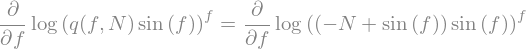



6
['differentiate', 5, N]


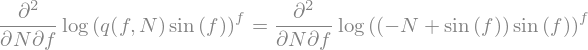

In [43]:
reconstruct_derivation(df[df.columns[:42]], 2091, True)

In [55]:
create_alternative_final_equations(df[df.columns[:42]], 0, 3)

(["Equality(Add(Function('v')(Symbol('t', commutative=True), Symbol('V', commutative=True)), Mul(Integer(-1), exp(Symbol('t', commutative=True)))), Add(Mul(Symbol('V', commutative=True), exp(Symbol('t', commutative=True))), Mul(Integer(-1), exp(Symbol('t', commutative=True)))))",
  "Equality(Integer(0), Add(Derivative(Mul(Symbol('V', commutative=True), exp(Symbol('t', commutative=True))), Tuple(Symbol('V', commutative=True), Integer(1))), Mul(Integer(-1), Derivative(Function('v')(Symbol('t', commutative=True), Symbol('V', commutative=True)), Tuple(Symbol('V', commutative=True), Integer(1))))))",
  "Equality(Derivative(Function('v')(Symbol('t', commutative=True), Symbol('V', commutative=True)), Tuple(Symbol('t', commutative=True), Integer(1))), Derivative(Mul(Symbol('V', commutative=True), exp(Symbol('t', commutative=True))), Tuple(Symbol('t', commutative=True), Integer(1))))",
  "Equality(Pow(Function('v')(Symbol('t', commutative=True), Symbol('V', commutative=True)), Symbol('t', commu

In [56]:
# skip to near end after generation if step != 6

bad_idxs = []
next_equation_data = []
loop = tqdm(range(len(df)))
for i in loop:
    try:
        next_equation_data.append(create_alternative_final_equations(df[df.columns[:42]], i, 3)[0])
        print((i, 'ok'))
    except:
        bad_idxs.append(i)
        print((i, 'bad'))

  0%|          | 0/12302 [00:00<?, ?it/s]

(0, 'ok')
(1, 'ok')
(2, 'ok')
(3, 'ok')
(4, 'ok')
(5, 'ok')
(6, 'ok')
(7, 'ok')
(8, 'ok')
(9, 'ok')
(10, 'ok')
(11, 'ok')
(12, 'ok')
(13, 'ok')
(14, 'ok')
(15, 'ok')
(16, 'ok')
(17, 'ok')
(18, 'ok')
(19, 'ok')
(20, 'ok')
(21, 'ok')
(22, 'ok')
(23, 'ok')
(24, 'ok')
(25, 'ok')
(26, 'ok')
(27, 'ok')
(28, 'ok')
(29, 'ok')
(30, 'ok')
(31, 'ok')
(32, 'ok')
(33, 'ok')
(34, 'ok')
(35, 'ok')
(36, 'ok')
(37, 'ok')
(38, 'ok')
(39, 'ok')
(40, 'ok')
(41, 'ok')
(42, 'ok')
(43, 'ok')
(44, 'ok')
(45, 'ok')
(46, 'ok')
(47, 'ok')
(48, 'ok')
(49, 'ok')
(50, 'ok')
(51, 'ok')
(52, 'ok')
(53, 'ok')
(54, 'ok')
(55, 'ok')
(56, 'ok')
(57, 'ok')
(58, 'ok')
(59, 'ok')
(60, 'ok')
(61, 'ok')
(62, 'ok')
(63, 'ok')
(64, 'ok')
(65, 'ok')
(66, 'ok')
(67, 'ok')
(68, 'ok')
(69, 'ok')
(70, 'ok')
(71, 'ok')
(72, 'ok')
(73, 'ok')
(74, 'ok')
(75, 'ok')
(76, 'ok')
(77, 'ok')
(78, 'ok')
(79, 'ok')
(80, 'ok')
(81, 'ok')
(82, 'ok')
(83, 'ok')
(84, 'ok')
(85, 'ok')
(86, 'ok')
(87, 'ok')
(88, 'ok')
(89, 'ok')
(90, 'ok')
(91, 'ok'

(692, 'ok')
(693, 'ok')
(694, 'ok')
(695, 'ok')
(696, 'ok')
(697, 'ok')
(698, 'ok')
(699, 'ok')
(700, 'ok')
(701, 'ok')
(702, 'ok')
(703, 'ok')
(704, 'ok')
(705, 'ok')
(706, 'ok')
(707, 'ok')
(708, 'ok')
(709, 'ok')
(710, 'ok')
(711, 'ok')
(712, 'ok')
(713, 'ok')
(714, 'ok')
(715, 'ok')
(716, 'ok')
(717, 'ok')
(718, 'ok')
(719, 'ok')
(720, 'ok')
(721, 'ok')
(722, 'ok')
(723, 'ok')
(724, 'ok')
(725, 'ok')
(726, 'ok')
(727, 'ok')
(728, 'ok')
(729, 'ok')
(730, 'ok')
(731, 'ok')
(732, 'ok')
(733, 'ok')
(734, 'ok')
(735, 'ok')
(736, 'ok')
(737, 'ok')
(738, 'ok')
(739, 'ok')
(740, 'ok')
(741, 'ok')
(742, 'ok')
(743, 'ok')
(744, 'ok')
(745, 'ok')
(746, 'ok')
(747, 'ok')
(748, 'ok')
(749, 'ok')
(750, 'ok')
(751, 'ok')
(752, 'ok')
(753, 'ok')
(754, 'ok')
(755, 'ok')
(756, 'ok')
(757, 'ok')
(758, 'ok')
(759, 'ok')
(760, 'ok')
(761, 'ok')
(762, 'ok')
(763, 'ok')
(764, 'ok')
(765, 'ok')
(766, 'ok')
(767, 'ok')
(768, 'ok')
(769, 'ok')
(770, 'ok')
(771, 'ok')
(772, 'ok')
(773, 'ok')
(774, 'ok')
(775

(1346, 'ok')
(1347, 'ok')
(1348, 'ok')
(1349, 'ok')
(1350, 'ok')
(1351, 'ok')
(1352, 'ok')
(1353, 'ok')
(1354, 'ok')
(1355, 'ok')
(1356, 'ok')
(1357, 'ok')
(1358, 'ok')
(1359, 'ok')
(1360, 'ok')
(1361, 'ok')
(1362, 'ok')
(1363, 'ok')
(1364, 'ok')
(1365, 'ok')
(1366, 'ok')
(1367, 'ok')
(1368, 'ok')
(1369, 'ok')
(1370, 'ok')
(1371, 'ok')
(1372, 'ok')
(1373, 'ok')
(1374, 'ok')
(1375, 'ok')
(1376, 'ok')
(1377, 'ok')
(1378, 'ok')
(1379, 'ok')
(1380, 'ok')
(1381, 'ok')
(1382, 'ok')
(1383, 'ok')
(1384, 'ok')
(1385, 'ok')
(1386, 'ok')
(1387, 'ok')
(1388, 'ok')
(1389, 'ok')
(1390, 'ok')
(1391, 'ok')
(1392, 'ok')
(1393, 'ok')
(1394, 'ok')
(1395, 'ok')
(1396, 'ok')
(1397, 'ok')
(1398, 'ok')
(1399, 'ok')
(1400, 'ok')
(1401, 'ok')
(1402, 'ok')
(1403, 'ok')
(1404, 'ok')
(1405, 'ok')
(1406, 'ok')
(1407, 'ok')
(1408, 'ok')
(1409, 'ok')
(1410, 'ok')
(1411, 'ok')
(1412, 'ok')
(1413, 'ok')
(1414, 'ok')
(1415, 'ok')
(1416, 'ok')
(1417, 'ok')
(1418, 'ok')
(1419, 'ok')
(1420, 'ok')
(1421, 'ok')
(1422, 'ok')

(1977, 'ok')
(1978, 'ok')
(1979, 'ok')
(1980, 'ok')
(1981, 'ok')
(1982, 'ok')
(1983, 'ok')
(1984, 'ok')
(1985, 'ok')
(1986, 'ok')
(1987, 'ok')
(1988, 'ok')
(1989, 'ok')
(1990, 'ok')
(1991, 'ok')
(1992, 'ok')
(1993, 'ok')
(1994, 'ok')
(1995, 'ok')
(1996, 'ok')
(1997, 'ok')
(1998, 'ok')
(1999, 'ok')
(2000, 'ok')
(2001, 'ok')
(2002, 'ok')
(2003, 'ok')
(2004, 'ok')
(2005, 'ok')
(2006, 'ok')
(2007, 'ok')
(2008, 'ok')
(2009, 'ok')
(2010, 'ok')
(2011, 'ok')
(2012, 'ok')
(2013, 'ok')
(2014, 'ok')
(2015, 'ok')
(2016, 'ok')
(2017, 'ok')
(2018, 'ok')
(2019, 'ok')
(2020, 'ok')
(2021, 'ok')
(2022, 'ok')
(2023, 'ok')
(2024, 'ok')
(2025, 'ok')
(2026, 'ok')
(2027, 'ok')
(2028, 'ok')
(2029, 'ok')
(2030, 'ok')
(2031, 'ok')
(2032, 'ok')
(2033, 'ok')
(2034, 'ok')
(2035, 'ok')
(2036, 'ok')
(2037, 'ok')
(2038, 'ok')
(2039, 'ok')
(2040, 'ok')
(2041, 'ok')
(2042, 'ok')
(2043, 'ok')
(2044, 'ok')
(2045, 'ok')
(2046, 'ok')
(2047, 'ok')
(2048, 'ok')
(2049, 'ok')
(2050, 'ok')
(2051, 'ok')
(2052, 'ok')
(2053, 'ok')

(2608, 'ok')
(2609, 'ok')
(2610, 'ok')
(2611, 'ok')
(2612, 'ok')
(2613, 'ok')
(2614, 'ok')
(2615, 'ok')
(2616, 'ok')
(2617, 'ok')
(2618, 'ok')
(2619, 'ok')
(2620, 'ok')
(2621, 'ok')
(2622, 'ok')
(2623, 'ok')
(2624, 'ok')
(2625, 'ok')
(2626, 'ok')
(2627, 'ok')
(2628, 'ok')
(2629, 'ok')
(2630, 'ok')
(2631, 'ok')
(2632, 'ok')
(2633, 'ok')
(2634, 'ok')
(2635, 'ok')
(2636, 'ok')
(2637, 'ok')
(2638, 'ok')
(2639, 'ok')
(2640, 'ok')
(2641, 'ok')
(2642, 'ok')
(2643, 'ok')
(2644, 'ok')
(2645, 'ok')
(2646, 'ok')
(2647, 'ok')
(2648, 'ok')
(2649, 'ok')
(2650, 'ok')
(2651, 'ok')
(2652, 'ok')
(2653, 'ok')
(2654, 'ok')
(2655, 'ok')
(2656, 'ok')
(2657, 'ok')
(2658, 'ok')
(2659, 'ok')
(2660, 'ok')
(2661, 'ok')
(2662, 'ok')
(2663, 'ok')
(2664, 'ok')
(2665, 'ok')
(2666, 'ok')
(2667, 'ok')
(2668, 'ok')
(2669, 'ok')
(2670, 'ok')
(2671, 'ok')
(2672, 'ok')
(2673, 'ok')
(2674, 'ok')
(2675, 'ok')
(2676, 'ok')
(2677, 'ok')
(2678, 'ok')
(2679, 'ok')
(2680, 'ok')
(2681, 'ok')
(2682, 'ok')
(2683, 'ok')
(2684, 'ok')

(3241, 'ok')
(3242, 'ok')
(3243, 'ok')
(3244, 'ok')
(3245, 'ok')
(3246, 'ok')
(3247, 'ok')
(3248, 'ok')
(3249, 'ok')
(3250, 'ok')
(3251, 'ok')
(3252, 'ok')
(3253, 'ok')
(3254, 'ok')
(3255, 'ok')
(3256, 'ok')
(3257, 'ok')
(3258, 'ok')
(3259, 'ok')
(3260, 'ok')
(3261, 'ok')
(3262, 'ok')
(3263, 'ok')
(3264, 'ok')
(3265, 'ok')
(3266, 'ok')
(3267, 'ok')
(3268, 'ok')
(3269, 'ok')
(3270, 'ok')
(3271, 'ok')
(3272, 'ok')
(3273, 'ok')
(3274, 'ok')
(3275, 'ok')
(3276, 'ok')
(3277, 'ok')
(3278, 'ok')
(3279, 'ok')
(3280, 'ok')
(3281, 'ok')
(3282, 'ok')
(3283, 'ok')
(3284, 'ok')
(3285, 'ok')
(3286, 'ok')
(3287, 'ok')
(3288, 'ok')
(3289, 'ok')
(3290, 'ok')
(3291, 'ok')
(3292, 'ok')
(3293, 'ok')
(3294, 'ok')
(3295, 'ok')
(3296, 'ok')
(3297, 'ok')
(3298, 'ok')
(3299, 'ok')
(3300, 'ok')
(3301, 'ok')
(3302, 'ok')
(3303, 'ok')
(3304, 'ok')
(3305, 'ok')
(3306, 'ok')
(3307, 'ok')
(3308, 'ok')
(3309, 'ok')
(3310, 'ok')
(3311, 'ok')
(3312, 'ok')
(3313, 'ok')
(3314, 'ok')
(3315, 'ok')
(3316, 'ok')
(3317, 'ok')

(3872, 'ok')
(3873, 'ok')
(3874, 'ok')
(3875, 'ok')
(3876, 'ok')
(3877, 'ok')
(3878, 'ok')
(3879, 'ok')
(3880, 'ok')
(3881, 'ok')
(3882, 'ok')
(3883, 'ok')
(3884, 'ok')
(3885, 'ok')
(3886, 'ok')
(3887, 'ok')
(3888, 'ok')
(3889, 'ok')
(3890, 'ok')
(3891, 'ok')
(3892, 'ok')
(3893, 'ok')
(3894, 'ok')
(3895, 'ok')
(3896, 'ok')
(3897, 'ok')
(3898, 'ok')
(3899, 'ok')
(3900, 'ok')
(3901, 'ok')
(3902, 'ok')
(3903, 'ok')
(3904, 'ok')
(3905, 'ok')
(3906, 'ok')
(3907, 'ok')
(3908, 'ok')
(3909, 'ok')
(3910, 'ok')
(3911, 'ok')
(3912, 'ok')
(3913, 'ok')
(3914, 'ok')
(3915, 'ok')
(3916, 'ok')
(3917, 'ok')
(3918, 'ok')
(3919, 'ok')
(3920, 'ok')
(3921, 'ok')
(3922, 'ok')
(3923, 'ok')
(3924, 'ok')
(3925, 'ok')
(3926, 'ok')
(3927, 'ok')
(3928, 'ok')
(3929, 'ok')
(3930, 'ok')
(3931, 'ok')
(3932, 'ok')
(3933, 'ok')
(3934, 'ok')
(3935, 'ok')
(3936, 'ok')
(3937, 'ok')
(3938, 'ok')
(3939, 'ok')
(3940, 'ok')
(3941, 'ok')
(3942, 'ok')
(3943, 'ok')
(3944, 'ok')
(3945, 'ok')
(3946, 'ok')
(3947, 'ok')
(3948, 'ok')

(4504, 'ok')
(4505, 'ok')
(4506, 'ok')
(4507, 'ok')
(4508, 'ok')
(4509, 'ok')
(4510, 'ok')
(4511, 'ok')
(4512, 'ok')
(4513, 'ok')
(4514, 'ok')
(4515, 'ok')
(4516, 'ok')
(4517, 'ok')
(4518, 'ok')
(4519, 'ok')
(4520, 'ok')
(4521, 'ok')
(4522, 'ok')
(4523, 'ok')
(4524, 'ok')
(4525, 'ok')
(4526, 'ok')
(4527, 'ok')
(4528, 'ok')
(4529, 'ok')
(4530, 'ok')
(4531, 'ok')
(4532, 'ok')
(4533, 'ok')
(4534, 'ok')
(4535, 'ok')
(4536, 'ok')
(4537, 'ok')
(4538, 'ok')
(4539, 'ok')
(4540, 'ok')
(4541, 'ok')
(4542, 'ok')
(4543, 'ok')
(4544, 'ok')
(4545, 'ok')
(4546, 'ok')
(4547, 'ok')
(4548, 'ok')
(4549, 'ok')
(4550, 'ok')
(4551, 'ok')
(4552, 'ok')
(4553, 'ok')
(4554, 'ok')
(4555, 'ok')
(4556, 'ok')
(4557, 'ok')
(4558, 'ok')
(4559, 'ok')
(4560, 'ok')
(4561, 'ok')
(4562, 'ok')
(4563, 'ok')
(4564, 'ok')
(4565, 'ok')
(4566, 'ok')
(4567, 'ok')
(4568, 'ok')
(4569, 'ok')
(4570, 'ok')
(4571, 'ok')
(4572, 'ok')
(4573, 'ok')
(4574, 'ok')
(4575, 'ok')
(4576, 'ok')
(4577, 'ok')
(4578, 'ok')
(4579, 'ok')
(4580, 'ok')

(5136, 'ok')
(5137, 'ok')
(5138, 'ok')
(5139, 'ok')
(5140, 'ok')
(5141, 'ok')
(5142, 'ok')
(5143, 'ok')
(5144, 'ok')
(5145, 'ok')
(5146, 'ok')
(5147, 'ok')
(5148, 'ok')
(5149, 'ok')
(5150, 'ok')
(5151, 'ok')
(5152, 'ok')
(5153, 'ok')
(5154, 'ok')
(5155, 'ok')
(5156, 'ok')
(5157, 'ok')
(5158, 'ok')
(5159, 'ok')
(5160, 'ok')
(5161, 'ok')
(5162, 'ok')
(5163, 'ok')
(5164, 'ok')
(5165, 'ok')
(5166, 'ok')
(5167, 'ok')
(5168, 'ok')
(5169, 'ok')
(5170, 'ok')
(5171, 'ok')
(5172, 'ok')
(5173, 'ok')
(5174, 'ok')
(5175, 'ok')
(5176, 'ok')
(5177, 'ok')
(5178, 'ok')
(5179, 'ok')
(5180, 'ok')
(5181, 'ok')
(5182, 'ok')
(5183, 'ok')
(5184, 'ok')
(5185, 'ok')
(5186, 'ok')
(5187, 'ok')
(5188, 'ok')
(5189, 'ok')
(5190, 'ok')
(5191, 'ok')
(5192, 'ok')
(5193, 'ok')
(5194, 'ok')
(5195, 'ok')
(5196, 'ok')
(5197, 'ok')
(5198, 'ok')
(5199, 'ok')
(5200, 'ok')
(5201, 'ok')
(5202, 'ok')
(5203, 'ok')
(5204, 'ok')
(5205, 'ok')
(5206, 'ok')
(5207, 'ok')
(5208, 'ok')
(5209, 'ok')
(5210, 'ok')
(5211, 'ok')
(5212, 'ok')

(5769, 'ok')
(5770, 'ok')
(5771, 'ok')
(5772, 'ok')
(5773, 'ok')
(5774, 'ok')
(5775, 'ok')
(5776, 'ok')
(5777, 'ok')
(5778, 'ok')
(5779, 'ok')
(5780, 'ok')
(5781, 'ok')
(5782, 'ok')
(5783, 'ok')
(5784, 'ok')
(5785, 'ok')
(5786, 'ok')
(5787, 'ok')
(5788, 'ok')
(5789, 'ok')
(5790, 'ok')
(5791, 'ok')
(5792, 'ok')
(5793, 'ok')
(5794, 'ok')
(5795, 'ok')
(5796, 'ok')
(5797, 'ok')
(5798, 'ok')
(5799, 'ok')
(5800, 'ok')
(5801, 'ok')
(5802, 'ok')
(5803, 'ok')
(5804, 'ok')
(5805, 'ok')
(5806, 'ok')
(5807, 'ok')
(5808, 'ok')
(5809, 'ok')
(5810, 'ok')
(5811, 'ok')
(5812, 'ok')
(5813, 'ok')
(5814, 'ok')
(5815, 'ok')
(5816, 'ok')
(5817, 'ok')
(5818, 'ok')
(5819, 'ok')
(5820, 'ok')
(5821, 'ok')
(5822, 'ok')
(5823, 'ok')
(5824, 'ok')
(5825, 'ok')
(5826, 'ok')
(5827, 'ok')
(5828, 'ok')
(5829, 'ok')
(5830, 'ok')
(5831, 'ok')
(5832, 'ok')
(5833, 'ok')
(5834, 'ok')
(5835, 'ok')
(5836, 'ok')
(5837, 'ok')
(5838, 'ok')
(5839, 'ok')
(5840, 'ok')
(5841, 'ok')
(5842, 'ok')
(5843, 'ok')
(5844, 'ok')
(5845, 'ok')

(6401, 'ok')
(6402, 'ok')
(6403, 'ok')
(6404, 'ok')
(6405, 'ok')
(6406, 'ok')
(6407, 'ok')
(6408, 'ok')
(6409, 'ok')
(6410, 'ok')
(6411, 'ok')
(6412, 'ok')
(6413, 'ok')
(6414, 'ok')
(6415, 'ok')
(6416, 'ok')
(6417, 'ok')
(6418, 'ok')
(6419, 'ok')
(6420, 'ok')
(6421, 'ok')
(6422, 'ok')
(6423, 'ok')
(6424, 'ok')
(6425, 'ok')
(6426, 'ok')
(6427, 'ok')
(6428, 'ok')
(6429, 'ok')
(6430, 'ok')
(6431, 'ok')
(6432, 'ok')
(6433, 'ok')
(6434, 'ok')
(6435, 'ok')
(6436, 'ok')
(6437, 'ok')
(6438, 'ok')
(6439, 'ok')
(6440, 'ok')
(6441, 'ok')
(6442, 'ok')
(6443, 'ok')
(6444, 'ok')
(6445, 'ok')
(6446, 'ok')
(6447, 'ok')
(6448, 'ok')
(6449, 'ok')
(6450, 'ok')
(6451, 'ok')
(6452, 'ok')
(6453, 'ok')
(6454, 'ok')
(6455, 'ok')
(6456, 'ok')
(6457, 'ok')
(6458, 'ok')
(6459, 'ok')
(6460, 'ok')
(6461, 'ok')
(6462, 'ok')
(6463, 'ok')
(6464, 'ok')
(6465, 'ok')
(6466, 'ok')
(6467, 'ok')
(6468, 'ok')
(6469, 'ok')
(6470, 'ok')
(6471, 'ok')
(6472, 'ok')
(6473, 'ok')
(6474, 'ok')
(6475, 'ok')
(6476, 'ok')
(6477, 'ok')

(7032, 'ok')
(7033, 'ok')
(7034, 'ok')
(7035, 'ok')
(7036, 'ok')
(7037, 'ok')
(7038, 'ok')
(7039, 'ok')
(7040, 'ok')
(7041, 'ok')
(7042, 'ok')
(7043, 'ok')
(7044, 'ok')
(7045, 'ok')
(7046, 'ok')
(7047, 'ok')
(7048, 'ok')
(7049, 'ok')
(7050, 'ok')
(7051, 'ok')
(7052, 'ok')
(7053, 'ok')
(7054, 'ok')
(7055, 'ok')
(7056, 'ok')
(7057, 'ok')
(7058, 'ok')
(7059, 'ok')
(7060, 'ok')
(7061, 'ok')
(7062, 'ok')
(7063, 'ok')
(7064, 'ok')
(7065, 'ok')
(7066, 'ok')
(7067, 'ok')
(7068, 'ok')
(7069, 'ok')
(7070, 'ok')
(7071, 'ok')
(7072, 'ok')
(7073, 'ok')
(7074, 'ok')
(7075, 'ok')
(7076, 'ok')
(7077, 'ok')
(7078, 'ok')
(7079, 'ok')
(7080, 'ok')
(7081, 'ok')
(7082, 'ok')
(7083, 'ok')
(7084, 'ok')
(7085, 'ok')
(7086, 'ok')
(7087, 'ok')
(7088, 'ok')
(7089, 'ok')
(7090, 'ok')
(7091, 'ok')
(7092, 'ok')
(7093, 'ok')
(7094, 'ok')
(7095, 'ok')
(7096, 'ok')
(7097, 'ok')
(7098, 'ok')
(7099, 'ok')
(7100, 'ok')
(7101, 'ok')
(7102, 'ok')
(7103, 'ok')
(7104, 'ok')
(7105, 'ok')
(7106, 'ok')
(7107, 'ok')
(7108, 'ok')

(7663, 'ok')
(7664, 'ok')
(7665, 'ok')
(7666, 'ok')
(7667, 'ok')
(7668, 'ok')
(7669, 'ok')
(7670, 'ok')
(7671, 'ok')
(7672, 'ok')
(7673, 'ok')
(7674, 'ok')
(7675, 'ok')
(7676, 'ok')
(7677, 'ok')
(7678, 'ok')
(7679, 'ok')
(7680, 'ok')
(7681, 'ok')
(7682, 'ok')
(7683, 'ok')
(7684, 'ok')
(7685, 'ok')
(7686, 'ok')
(7687, 'ok')
(7688, 'ok')
(7689, 'ok')
(7690, 'ok')
(7691, 'ok')
(7692, 'ok')
(7693, 'ok')
(7694, 'ok')
(7695, 'ok')
(7696, 'ok')
(7697, 'ok')
(7698, 'ok')
(7699, 'ok')
(7700, 'ok')
(7701, 'ok')
(7702, 'ok')
(7703, 'ok')
(7704, 'ok')
(7705, 'ok')
(7706, 'ok')
(7707, 'ok')
(7708, 'ok')
(7709, 'ok')
(7710, 'ok')
(7711, 'ok')
(7712, 'ok')
(7713, 'ok')
(7714, 'ok')
(7715, 'ok')
(7716, 'ok')
(7717, 'ok')
(7718, 'ok')
(7719, 'ok')
(7720, 'ok')
(7721, 'ok')
(7722, 'ok')
(7723, 'ok')
(7724, 'ok')
(7725, 'ok')
(7726, 'ok')
(7727, 'ok')
(7728, 'ok')
(7729, 'ok')
(7730, 'ok')
(7731, 'ok')
(7732, 'ok')
(7733, 'ok')
(7734, 'ok')
(7735, 'ok')
(7736, 'ok')
(7737, 'ok')
(7738, 'ok')
(7739, 'ok')

(8294, 'ok')
(8295, 'ok')
(8296, 'ok')
(8297, 'ok')
(8298, 'ok')
(8299, 'ok')
(8300, 'ok')
(8301, 'ok')
(8302, 'ok')
(8303, 'ok')
(8304, 'ok')
(8305, 'ok')
(8306, 'ok')
(8307, 'ok')
(8308, 'ok')
(8309, 'ok')
(8310, 'ok')
(8311, 'ok')
(8312, 'ok')
(8313, 'ok')
(8314, 'ok')
(8315, 'ok')
(8316, 'ok')
(8317, 'ok')
(8318, 'ok')
(8319, 'ok')
(8320, 'ok')
(8321, 'ok')
(8322, 'ok')
(8323, 'ok')
(8324, 'ok')
(8325, 'ok')
(8326, 'ok')
(8327, 'ok')
(8328, 'ok')
(8329, 'ok')
(8330, 'ok')
(8331, 'ok')
(8332, 'ok')
(8333, 'ok')
(8334, 'ok')
(8335, 'ok')
(8336, 'ok')
(8337, 'ok')
(8338, 'ok')
(8339, 'ok')
(8340, 'ok')
(8341, 'ok')
(8342, 'ok')
(8343, 'ok')
(8344, 'ok')
(8345, 'ok')
(8346, 'ok')
(8347, 'ok')
(8348, 'ok')
(8349, 'ok')
(8350, 'ok')
(8351, 'ok')
(8352, 'ok')
(8353, 'ok')
(8354, 'ok')
(8355, 'ok')
(8356, 'ok')
(8357, 'ok')
(8358, 'ok')
(8359, 'ok')
(8360, 'ok')
(8361, 'ok')
(8362, 'ok')
(8363, 'ok')
(8364, 'ok')
(8365, 'ok')
(8366, 'ok')
(8367, 'ok')
(8368, 'ok')
(8369, 'ok')
(8370, 'ok')

(8926, 'ok')
(8927, 'ok')
(8928, 'ok')
(8929, 'ok')
(8930, 'ok')
(8931, 'ok')
(8932, 'ok')
(8933, 'ok')
(8934, 'ok')
(8935, 'ok')
(8936, 'ok')
(8937, 'ok')
(8938, 'ok')
(8939, 'ok')
(8940, 'ok')
(8941, 'ok')
(8942, 'ok')
(8943, 'ok')
(8944, 'ok')
(8945, 'ok')
(8946, 'ok')
(8947, 'ok')
(8948, 'ok')
(8949, 'ok')
(8950, 'ok')
(8951, 'ok')
(8952, 'ok')
(8953, 'ok')
(8954, 'ok')
(8955, 'ok')
(8956, 'ok')
(8957, 'ok')
(8958, 'ok')
(8959, 'ok')
(8960, 'ok')
(8961, 'ok')
(8962, 'ok')
(8963, 'ok')
(8964, 'ok')
(8965, 'ok')
(8966, 'ok')
(8967, 'ok')
(8968, 'ok')
(8969, 'ok')
(8970, 'ok')
(8971, 'ok')
(8972, 'ok')
(8973, 'ok')
(8974, 'ok')
(8975, 'ok')
(8976, 'ok')
(8977, 'ok')
(8978, 'ok')
(8979, 'ok')
(8980, 'ok')
(8981, 'ok')
(8982, 'ok')
(8983, 'ok')
(8984, 'ok')
(8985, 'ok')
(8986, 'ok')
(8987, 'ok')
(8988, 'ok')
(8989, 'ok')
(8990, 'ok')
(8991, 'ok')
(8992, 'ok')
(8993, 'ok')
(8994, 'ok')
(8995, 'ok')
(8996, 'ok')
(8997, 'ok')
(8998, 'ok')
(8999, 'ok')
(9000, 'ok')
(9001, 'ok')
(9002, 'ok')

(9557, 'ok')
(9558, 'ok')
(9559, 'ok')
(9560, 'ok')
(9561, 'ok')
(9562, 'ok')
(9563, 'ok')
(9564, 'ok')
(9565, 'ok')
(9566, 'ok')
(9567, 'ok')
(9568, 'ok')
(9569, 'ok')
(9570, 'ok')
(9571, 'ok')
(9572, 'ok')
(9573, 'ok')
(9574, 'ok')
(9575, 'ok')
(9576, 'ok')
(9577, 'ok')
(9578, 'ok')
(9579, 'ok')
(9580, 'ok')
(9581, 'ok')
(9582, 'ok')
(9583, 'ok')
(9584, 'ok')
(9585, 'ok')
(9586, 'ok')
(9587, 'ok')
(9588, 'ok')
(9589, 'ok')
(9590, 'ok')
(9591, 'ok')
(9592, 'ok')
(9593, 'ok')
(9594, 'ok')
(9595, 'ok')
(9596, 'ok')
(9597, 'ok')
(9598, 'ok')
(9599, 'ok')
(9600, 'ok')
(9601, 'ok')
(9602, 'ok')
(9603, 'ok')
(9604, 'ok')
(9605, 'ok')
(9606, 'ok')
(9607, 'ok')
(9608, 'ok')
(9609, 'ok')
(9610, 'ok')
(9611, 'ok')
(9612, 'ok')
(9613, 'ok')
(9614, 'ok')
(9615, 'ok')
(9616, 'ok')
(9617, 'ok')
(9618, 'ok')
(9619, 'ok')
(9620, 'ok')
(9621, 'ok')
(9622, 'ok')
(9623, 'ok')
(9624, 'ok')
(9625, 'ok')
(9626, 'ok')
(9627, 'ok')
(9628, 'ok')
(9629, 'ok')
(9630, 'ok')
(9631, 'ok')
(9632, 'ok')
(9633, 'ok')

(10174, 'ok')
(10175, 'ok')
(10176, 'ok')
(10177, 'ok')
(10178, 'ok')
(10179, 'ok')
(10180, 'ok')
(10181, 'ok')
(10182, 'ok')
(10183, 'ok')
(10184, 'ok')
(10185, 'ok')
(10186, 'ok')
(10187, 'ok')
(10188, 'ok')
(10189, 'ok')
(10190, 'ok')
(10191, 'ok')
(10192, 'ok')
(10193, 'ok')
(10194, 'ok')
(10195, 'ok')
(10196, 'ok')
(10197, 'ok')
(10198, 'ok')
(10199, 'ok')
(10200, 'ok')
(10201, 'ok')
(10202, 'ok')
(10203, 'ok')
(10204, 'ok')
(10205, 'ok')
(10206, 'ok')
(10207, 'ok')
(10208, 'ok')
(10209, 'ok')
(10210, 'ok')
(10211, 'ok')
(10212, 'ok')
(10213, 'ok')
(10214, 'ok')
(10215, 'ok')
(10216, 'ok')
(10217, 'ok')
(10218, 'ok')
(10219, 'ok')
(10220, 'ok')
(10221, 'ok')
(10222, 'ok')
(10223, 'ok')
(10224, 'ok')
(10225, 'ok')
(10226, 'ok')
(10227, 'ok')
(10228, 'ok')
(10229, 'ok')
(10230, 'ok')
(10231, 'ok')
(10232, 'ok')
(10233, 'ok')
(10234, 'ok')
(10235, 'ok')
(10236, 'ok')
(10237, 'ok')
(10238, 'ok')
(10239, 'ok')
(10240, 'ok')
(10241, 'ok')
(10242, 'ok')
(10243, 'ok')
(10244, 'ok')
(10245

(10761, 'ok')
(10762, 'ok')
(10763, 'ok')
(10764, 'ok')
(10765, 'ok')
(10766, 'ok')
(10767, 'ok')
(10768, 'ok')
(10769, 'ok')
(10770, 'ok')
(10771, 'ok')
(10772, 'ok')
(10773, 'ok')
(10774, 'ok')
(10775, 'ok')
(10776, 'ok')
(10777, 'ok')
(10778, 'ok')
(10779, 'ok')
(10780, 'ok')
(10781, 'ok')
(10782, 'ok')
(10783, 'ok')
(10784, 'ok')
(10785, 'ok')
(10786, 'ok')
(10787, 'ok')
(10788, 'ok')
(10789, 'ok')
(10790, 'ok')
(10791, 'ok')
(10792, 'ok')
(10793, 'ok')
(10794, 'ok')
(10795, 'ok')
(10796, 'ok')
(10797, 'ok')
(10798, 'ok')
(10799, 'ok')
(10800, 'ok')
(10801, 'ok')
(10802, 'ok')
(10803, 'ok')
(10804, 'ok')
(10805, 'ok')
(10806, 'ok')
(10807, 'ok')
(10808, 'ok')
(10809, 'ok')
(10810, 'ok')
(10811, 'ok')
(10812, 'ok')
(10813, 'ok')
(10814, 'ok')
(10815, 'ok')
(10816, 'ok')
(10817, 'ok')
(10818, 'ok')
(10819, 'ok')
(10820, 'ok')
(10821, 'ok')
(10822, 'ok')
(10823, 'ok')
(10824, 'ok')
(10825, 'ok')
(10826, 'ok')
(10827, 'ok')
(10828, 'ok')
(10829, 'ok')
(10830, 'ok')
(10831, 'ok')
(10832

(11348, 'ok')
(11349, 'ok')
(11350, 'ok')
(11351, 'ok')
(11352, 'ok')
(11353, 'ok')
(11354, 'ok')
(11355, 'ok')
(11356, 'ok')
(11357, 'ok')
(11358, 'ok')
(11359, 'ok')
(11360, 'ok')
(11361, 'ok')
(11362, 'ok')
(11363, 'ok')
(11364, 'ok')
(11365, 'ok')
(11366, 'ok')
(11367, 'ok')
(11368, 'ok')
(11369, 'ok')
(11370, 'ok')
(11371, 'ok')
(11372, 'ok')
(11373, 'ok')
(11374, 'ok')
(11375, 'ok')
(11376, 'ok')
(11377, 'ok')
(11378, 'ok')
(11379, 'ok')
(11380, 'ok')
(11381, 'ok')
(11382, 'ok')
(11383, 'ok')
(11384, 'ok')
(11385, 'ok')
(11386, 'ok')
(11387, 'ok')
(11388, 'ok')
(11389, 'ok')
(11390, 'ok')
(11391, 'ok')
(11392, 'ok')
(11393, 'ok')
(11394, 'ok')
(11395, 'ok')
(11396, 'ok')
(11397, 'ok')
(11398, 'ok')
(11399, 'ok')
(11400, 'ok')
(11401, 'ok')
(11402, 'ok')
(11403, 'ok')
(11404, 'ok')
(11405, 'ok')
(11406, 'ok')
(11407, 'ok')
(11408, 'ok')
(11409, 'ok')
(11410, 'ok')
(11411, 'ok')
(11412, 'ok')
(11413, 'ok')
(11414, 'ok')
(11415, 'ok')
(11416, 'ok')
(11417, 'ok')
(11418, 'ok')
(11419

(11934, 'ok')
(11935, 'ok')
(11936, 'ok')
(11937, 'ok')
(11938, 'ok')
(11939, 'ok')
(11940, 'ok')
(11941, 'ok')
(11942, 'ok')
(11943, 'ok')
(11944, 'ok')
(11945, 'ok')
(11946, 'ok')
(11947, 'ok')
(11948, 'ok')
(11949, 'ok')
(11950, 'ok')
(11951, 'ok')
(11952, 'ok')
(11953, 'ok')
(11954, 'ok')
(11955, 'ok')
(11956, 'ok')
(11957, 'ok')
(11958, 'ok')
(11959, 'ok')
(11960, 'ok')
(11961, 'ok')
(11962, 'ok')
(11963, 'ok')
(11964, 'ok')
(11965, 'ok')
(11966, 'ok')
(11967, 'ok')
(11968, 'ok')
(11969, 'ok')
(11970, 'ok')
(11971, 'ok')
(11972, 'ok')
(11973, 'ok')
(11974, 'ok')
(11975, 'ok')
(11976, 'ok')
(11977, 'ok')
(11978, 'ok')
(11979, 'ok')
(11980, 'ok')
(11981, 'ok')
(11982, 'ok')
(11983, 'ok')
(11984, 'ok')
(11985, 'ok')
(11986, 'ok')
(11987, 'ok')
(11988, 'ok')
(11989, 'ok')
(11990, 'ok')
(11991, 'ok')
(11992, 'ok')
(11993, 'ok')
(11994, 'ok')
(11995, 'ok')
(11996, 'ok')
(11997, 'ok')
(11998, 'ok')
(11999, 'ok')
(12000, 'ok')
(12001, 'ok')
(12002, 'ok')
(12003, 'ok')
(12004, 'ok')
(12005

In [57]:
bad_idxs

In [61]:
df = pd.DataFrame([df.iloc[i] for i in range(len(df)) if i not in bad_idxs], columns=df.columns)
df.index = range(len(df))
df

,eq_idx_1,rule_1,arg_11,arg_12,arg_12_srepr,eq_1_srepr,eq_1,eq_idx_2,rule_2,arg_21,...,arg_52_srepr,eq_5_srepr,eq_5,eq_idx_6,rule_6,arg_61,arg_62,arg_62_srepr,eq_6_srepr,eq_6
0,1,premise,,,,"Equality(Function('h')(Symbol('v', commutative...",h{\left(v \right)} = \log{\left(v \right)},2,differentiate,1,...,"Symbol('v', commutative=True)","Equality(Integral(Derivative(log(Symbol('v', c...","\int \frac{d}{d v} \log{\left(v \right)}\, dv ...",6,evaluate_integrals,5,,,"Equality(Add(Symbol('R', commutative=True), lo...",R + \log{\left(v \right)} = j + \log{\left(v \...
1,1,premise,,,,"Equality(Function('T')(Symbol('l', commutative...",T{\left(l \right)} = \cos{\left(l \right)},2,divide,1,...,,"Equality(Mul(Function('L')(Symbol('l', commuta...",\frac{L{\left(l \right)}}{\cos{\left(l \right)...,6,differentiate,5,l,"Symbol('l', commutative=True)",Equality(Derivative(Mul(Function('L')(Symbol('...,\frac{d}{d l} \frac{L{\left(l \right)}}{\cos{\...
2,1,premise,,,,"Equality(Function('E')(Symbol('B', commutative...","E{\left(B,u,Z \right)} = \frac{- Z + u}{B}",2,integrate,1,...,,"Equality(Add(Symbol('n', commutative=True), Mu...",n - \frac{Z u}{B} + \frac{u^{2}}{2 B} = L - \f...,6,integrate,5,L,"Symbol('L', commutative=True)","Equality(Integral(Add(Symbol('n', commutative=...",\int \left(n - \frac{Z u}{B} + \frac{u^{2}}{2 ...
3,1,premise,,,,"Equality(Function('X')(Symbol('c', commutative...",X{\left(c \right)} = \cos{\left(e^{c} \right)},2,differentiate,1,...,"cos(exp(Symbol('c', commutative=True)))","Equality(Mul(Function('F')(Symbol('c', commuta...",F{\left(c \right)} \cos{\left(e^{c} \right)} =...,6,substitute_RHS_for_LHS,5,2,,"Equality(Mul(Function('F')(Symbol('c', commuta...",F{\left(c \right)} \cos{\left(e^{c} \right)} =...
4,1,premise,,,,"Equality(Function('o')(Symbol('M', commutative...",o{\left(M \right)} = \sin{\left(M \right)},2,power,1,...,,"Equality(Function('B')(Symbol('M', commutative...",B{\left(M \right)} = \int \sin^{M}{\left(M \ri...,6,sin,5,,,"Equality(sin(Function('B')(Symbol('M', commuta...",\sin{\left(B{\left(M \right)} \right)} = \sin{...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,1,premise,,,,"Equality(Function('C')(Symbol('c', commutative...","C{\left(c,x \right)} = c \sin{\left(x \right)}",2,times,1,...,,"Equality(Add(Mul(Integer(2), Pow(Symbol('c', c...",2 c^{2} \sin{\left(x \right)} \cos{\left(x \ri...,6,substitute_LHS_for_RHS,5,1,,"Equality(Add(Mul(Integer(3), Pow(Symbol('c', c...",3 c^{2} \sin{\left(x \right)} \cos{\left(x \ri...
2093,1,premise,,,,"Equality(Function('b')(Symbol('L', commutative...","b{\left(L,y \right)} = L^{y}",2,add,1,...,,"Equality(Derivative(Function('b')(Symbol('L', ...","\frac{\partial}{\partial L} b{\left(L,y \right...",6,substitute_LHS_for_RHS,5,4,,"Equality(Mul(Pow(Symbol('L', commutative=True)...","\frac{L^{y} y}{L} = \frac{y b{\left(L,y \right..."
2094,1,premise,,,,"Equality(Function('t')(Symbol('w', commutative...","t{\left(w,l \right)} = \sin{\left(l w \right)}",2,integrate,1,...,,"Equality(Function('Y')(Symbol('w', commutative...","Y{\left(w,l \right)} = l w",6,substitute_RHS_for_LHS,4,5,,"Equality(Add(Function('t')(Symbol('w', commuta...","t{\left(w,l \right)} + \int t{\left(w,l \right..."
2095,1,premise,,,,"Equality(Function('u')(Symbol('k', commutative...","u{\left(k,D,v \right)} = - D + k + v",2,add,1,...,,"Equality(Function('u')(Symbol('k', commutative...","u{\left(k,D,v \right)} = k + v + Q{\left(D \ri...",6,substitute_LHS_for_RHS,3,5,,"Equality(Pow(Add(Symbol('k', commutative=True)...",\left(k + 2 v + Q{\left(D \right)}\right)^{2} ...


In [58]:
len(next_equation_data)

In [59]:
cols = ['neg_1_srepr', 'neg_2_srepr', 'neg_3_srepr', 'neg_4_srepr', 'neg_1', 'neg_2', 'neg_3', 'neg_4']

pd.DataFrame(next_equation_data, columns=cols)

,neg_1_srepr,neg_2_srepr,neg_3_srepr,neg_4_srepr,neg_1,neg_2,neg_3,neg_4
0,"Equality(Derivative(Function('v')(Symbol('t', ...",Equality(Integral(Derivative(Function('v')(Sym...,"Equality(Integral(Function('v')(Symbol('t', co...","Equality(Integral(Function('v')(Symbol('t', co...","\frac{\partial}{\partial t} v{\left(t,V \right...","\int \frac{\partial}{\partial V} v{\left(t,V \...","\int v{\left(t,V \right)}\, dt = \int V e^{t}\...","\int v{\left(t,V \right)}\, dV = \int V e^{t}\..."
1,"Equality(cos(Function('X')(Symbol('I', commuta...","Equality(exp(Mul(Integer(2), Function('X')(Sym...","Equality(Integral(Mul(Integer(2), Function('X'...","Equality(Derivative(Mul(Integer(2), Function('...",\cos{\left(X{\left(I \right)} \right)} = \cos{...,e^{2 X{\left(I \right)}} = e^{X{\left(I \right...,"\int 2 X{\left(I \right)}\, dI = \int \left(X{...",\frac{d}{d I} 2 X{\left(I \right)} = \frac{d}{...
2,"Equality(Integral(Function('X')(Symbol('R', co...","Equality(Mul(Add(Mul(Integer(-1), Symbol('q', ...","Equality(exp(Function('X')(Symbol('R', commuta...","Equality(Mul(Integer(-1), Symbol('q', commutat...","\int X{\left(R,q \right)}\, dq = \int \cos{\le...","\left(- q + X{\left(R,q \right)}\right) X{\lef...","e^{X{\left(R,q \right)}} = e^{\cos{\left(R - q...","- q \left(- q + X{\left(R,q \right)}\right) = ..."
3,Equality(Integral(Pow(Function('C')(Symbol('z'...,"Equality(Add(Mul(Integer(-1), Function('C')(Sy...","Equality(Integer(0), Add(Mul(Integer(-1), Pow(...","Equality(Add(Symbol('z', commutative=True), Fu...","\int C^{z}{\left(z \right)}\, dz = \int \sin^{...",- C{\left(z \right)} + C^{z}{\left(z \right)} ...,0 = - C^{z}{\left(z \right)} + \sin^{z}{\left(...,z + C{\left(z \right)} = z + \sin{\left(z \rig...
4,"Equality(cos(Function('S')(Symbol('Z', commuta...","Equality(Mul(Function('S')(Symbol('Z', commuta...","Equality(Add(Function('S')(Symbol('Z', commuta...","Equality(Mul(Pow(Symbol('o', commutative=True)...","\cos{\left(S{\left(Z,o \right)} \right)} = \co...","S{\left(Z,o \right)} \frac{\partial}{\partial ...","S{\left(Z,o \right)} + \frac{\partial}{\partia...","\frac{\frac{\partial}{\partial Z} S{\left(Z,o ..."
...,...,...,...,...,...,...,...,...
12297,"Equality(Add(Mul(Integer(-1), Symbol('E', comm...","Equality(Mul(Rational(1, 2), Pow(Symbol('g', c...","Equality(Add(Mul(Symbol('g', commutative=True)...","Equality(Pow(Add(Mul(Symbol('g', commutative=T...","- E + H{\left(g,E \right)} = - E + g \log{\lef...","\frac{H{\left(g,E \right)}}{2 g \log{\left(E \...","g \log{\left(E \right)} + 2 H{\left(g,E \right...","\left(g \log{\left(E \right)} + H{\left(g,E \r..."
12298,"Equality(Derivative(Function('G')(Symbol('D', ...","Equality(Integral(Function('G')(Symbol('D', co...",Equality(Derivative(Pow(Function('G')(Symbol('...,"Equality(sin(Pow(Function('G')(Symbol('D', com...","\frac{\partial}{\partial M} G{\left(D,M \right...","\int G{\left(D,M \right)}\, dD = \int \left(D ...","\frac{\partial}{\partial M} G^{M}{\left(D,M \r...","\sin{\left(G^{M}{\left(D,M \right)} \right)} =..."
12299,Equality(Integral(Add(Function('A')(Symbol('y'...,"Equality(Mul(Add(Mul(Integer(-1), log(Symbol('...","Equality(Derivative(Function('A')(Symbol('y', ...","Equality(cos(Add(Function('A')(Symbol('y', com...",\int \left(A{\left(y \right)} - \log{\left(y \...,\left(- \log{\left(y \right)} + \cos{\left(\lo...,\frac{d}{d y} A{\left(y \right)} = \frac{d}{d ...,\cos{\left(A{\left(y \right)} - \log{\left(y \...
12300,"Equality(Integral(Function('b')(Symbol('g', co...","Equality(Integral(Function('b')(Symbol('g', co...",Equality(cos(Integral(Function('b')(Symbol('g'...,"Equality(Integral(Function('b')(Symbol('g', co...","\iint b{\left(g,A,n \right)}\, dg\, dA = \iint...","\int b{\left(g,A,n \right)}\, dn = \int \left(...","\cos{\left(\int b{\left(g,A,n \right)}\, dg \r...","\int b{\left(g,A,n \right)}\, dg = \int A\, dg..."


In [60]:
new_df = pd.concat([df[df.columns[:42]], pd.DataFrame(next_equation_data, columns=cols)], axis=1)

new_df

,eq_idx_1,rule_1,arg_11,arg_12,arg_12_srepr,eq_1_srepr,eq_1,eq_idx_2,rule_2,arg_21,...,eq_6_srepr,eq_6,neg_1_srepr,neg_2_srepr,neg_3_srepr,neg_4_srepr,neg_1,neg_2,neg_3,neg_4
0,1,premise,,,,"Equality(Function('v')(Symbol('t', commutative...","v{\left(t,V \right)} = V e^{t}",2,differentiate,1,...,"Equality(Derivative(Mul(Symbol('V', commutativ...",\frac{\partial}{\partial V} V \frac{\partial}{...,"Equality(Derivative(Function('v')(Symbol('t', ...",Equality(Integral(Derivative(Function('v')(Sym...,"Equality(Integral(Function('v')(Symbol('t', co...","Equality(Integral(Function('v')(Symbol('t', co...","\frac{\partial}{\partial t} v{\left(t,V \right...","\int \frac{\partial}{\partial V} v{\left(t,V \...","\int v{\left(t,V \right)}\, dt = \int V e^{t}\...","\int v{\left(t,V \right)}\, dV = \int V e^{t}\..."
1,1,premise,,,,"Equality(Function('X')(Symbol('I', commutative...",X{\left(I \right)} = \cos{\left(I \right)},2,add,1,...,"Equality(Mul(Pow(Mul(Integer(2), Function('X')...",\frac{\left(2 X{\left(I \right)}\right)^{I}}{\...,"Equality(cos(Function('X')(Symbol('I', commuta...","Equality(exp(Mul(Integer(2), Function('X')(Sym...","Equality(Integral(Mul(Integer(2), Function('X'...","Equality(Derivative(Mul(Integer(2), Function('...",\cos{\left(X{\left(I \right)} \right)} = \cos{...,e^{2 X{\left(I \right)}} = e^{X{\left(I \right...,"\int 2 X{\left(I \right)}\, dI = \int \left(X{...",\frac{d}{d I} 2 X{\left(I \right)} = \frac{d}{...
2,1,premise,,,,"Equality(Function('X')(Symbol('R', commutative...","X{\left(R,q \right)} = \cos{\left(R - q \right)}",2,minus,1,...,"Equality(Mul(Pow(Add(Symbol('R', commutative=T...",\frac{\left(- q + \cos{\left(R - q \right)}\ri...,"Equality(Integral(Function('X')(Symbol('R', co...","Equality(Mul(Add(Mul(Integer(-1), Symbol('q', ...","Equality(exp(Function('X')(Symbol('R', commuta...","Equality(Mul(Integer(-1), Symbol('q', commutat...","\int X{\left(R,q \right)}\, dq = \int \cos{\le...","\left(- q + X{\left(R,q \right)}\right) X{\lef...","e^{X{\left(R,q \right)}} = e^{\cos{\left(R - q...","- q \left(- q + X{\left(R,q \right)}\right) = ..."
3,1,premise,,,,"Equality(Function('C')(Symbol('z', commutative...",C{\left(z \right)} = \sin{\left(z \right)},2,power,1,...,"Equality(Mul(Add(Mul(Symbol('z', commutative=T...",\left(\frac{z \frac{d}{d z} \sin{\left(z \righ...,Equality(Integral(Pow(Function('C')(Symbol('z'...,"Equality(Add(Mul(Integer(-1), Function('C')(Sy...","Equality(Integer(0), Add(Mul(Integer(-1), Pow(...","Equality(Add(Symbol('z', commutative=True), Fu...","\int C^{z}{\left(z \right)}\, dz = \int \sin^{...",- C{\left(z \right)} + C^{z}{\left(z \right)} ...,0 = - C^{z}{\left(z \right)} + \sin^{z}{\left(...,z + C{\left(z \right)} = z + \sin{\left(z \rig...
4,1,premise,,,,"Equality(Function('S')(Symbol('Z', commutative...","S{\left(Z,o \right)} = \int \frac{Z}{o}\, dZ",2,differentiate,1,...,"Equality(Add(Function('S')(Symbol('Z', commuta...","S{\left(Z,o \right)} - 2 \frac{\partial}{\part...","Equality(cos(Function('S')(Symbol('Z', commuta...","Equality(Mul(Function('S')(Symbol('Z', commuta...","Equality(Add(Function('S')(Symbol('Z', commuta...","Equality(Mul(Pow(Symbol('o', commutative=True)...","\cos{\left(S{\left(Z,o \right)} \right)} = \co...","S{\left(Z,o \right)} \frac{\partial}{\partial ...","S{\left(Z,o \right)} + \frac{\partial}{\partia...","\frac{\frac{\partial}{\partial Z} S{\left(Z,o ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12297,1,premise,,,,"Equality(Function('H')(Symbol('g', commutative...","H{\left(g,E \right)} = g \log{\left(E \right)}",2,add,1,...,"Equality(Add(log(Symbol('E', commutative=True)...",\log{\left(E \right)} + \frac{\partial}{\parti...,"Equality(Add(Mul(Integer(-1), Symbol('E', comm...","Equality(Mul(Rational(1, 2), Pow(Symbol('g', c...","Equality(Add(Mul(Symbol('g', commutative=True)...","Equality(Pow(Add(Mul(Symbol('g', commutative=T...","- E + H{\left(g,E \right)} = - E + g \log{\lef...","\frac{H{\left(g,E \right)}}{2 

In [61]:
new_df.to_pickle('temp_df.pkl')

**Variable renaming** (also used to clean data further by removing incompatible derivations with weird function arguments)

In [42]:
df = pd.read_pickle('temp_df.pkl')

In [42]:
def get_free_symbols_from_derivation(d):
    free_symbols = []
    
    for step in d:
        free_symbols.extend(list(step[0].free_symbols))
    
    return list(dict.fromkeys(free_symbols))

In [43]:
def get_functions_from_derivation(d):
    functions = []

    for step in d:
        functions.extend(get_equation_elements(step[0]))

    return list(dict.fromkeys([i for i in functions if len(str(type(i))) == 1]))

In [44]:
rename_function = lambda function, sym: sp.Function(sym)(*tuple(function.free_symbols))

In [45]:
def get_swap_list(d, symbols, unseen_symbols):

    target_elements = get_functions_from_derivation(d) + get_free_symbols_from_derivation(d)
    #display(target_elements)

    bad_symbols = [symbol(str(type(i))) for i in get_functions_from_derivation(d)] + get_free_symbols_from_derivation(d)
    #display(bad_symbols)

    alternative_symbols = []
    while len(alternative_symbols) < len(target_elements):
        sym = random.choice(unseen_symbols)
        if (sym not in bad_symbols) and (sym not in alternative_symbols):
            alternative_symbols.append(sym)

    #display(alternative_symbols)


    swap_list = []
    for i in range(len(target_elements)):

        elem = target_elements[i]
        sym = alternative_symbols[i]

        if len(str(type(elem))) == 1:
            #display(rename_function(elem, sym))
            swap_list.append([elem, rename_function(elem, sym)])

        else:
            swap_list.append([elem, sym])

    return swap_list

In [46]:
get_derivation_and_negative_examples = lambda df, i: (reconstruct_derivation(df[df.columns[:42]], i), [sp.sympify(i) for i in list(df[df.columns[42:46]].iloc[i])])

In [47]:
is_math = lambda elem: str(elem) not in string.digits and type(elem) is not str

In [48]:
def rename_variables(math, swaps):
    
    for pair in swaps:
        math = math.subs(pair[0], pair[1])
    
    return math

In [49]:
def equation_contains_complicated_operand(eq):
    
    funcs = get_equation_elements(eq)

    funcs = list(dict.fromkeys([i for i in funcs if len(str(type(i))) == 1]))

    func_args = []
    for func in funcs:
        func_args.extend(list(func.args))

    arg_lens = [len(str(arg)) for arg in func_args if len(str(arg)) > 1]

    if arg_lens:
        return True

    else:
        return False

In [50]:
def contains_a_func_of_a_complicated_operand(df, i):

    d, negs = get_derivation_and_negative_examples(df, i)

    eqs = [i[0] for i in d] + negs

    funcs = []
    for eq in eqs:
        funcs.extend(get_equation_elements(eq))

    funcs = list(dict.fromkeys([i for i in funcs if len(str(type(i))) == 1]))

    func_args = []
    for func in funcs:
        func_args.extend(list(func.args))

    arg_lens = [len(str(arg)) for arg in func_args if len(str(arg)) > 1]

    if arg_lens:
        return True

    else:
        return False

In [51]:
def example_contains_a_func_of_a_complicated_operand(example):

    d, negs = get_derivation_from_example(example, negative_equations=True)

    eqs = [i[0] for i in d] + negs

    funcs = []
    for eq in eqs:
        funcs.extend(get_equation_elements(eq))

    funcs = list(dict.fromkeys([i for i in funcs if len(str(type(i))) == 1]))

    func_args = []
    for func in funcs:
        func_args.extend(list(func.args))

    arg_lens = [len(str(arg)) for arg in func_args if len(str(arg)) > 1]

    if arg_lens:
        return True

    else:
        return False

In [ ]:
# this identifies all df entries with weird functions

bad_idxs = []

loop = tqdm(range(len(df)))

for i in loop:
    
    try:
        if contains_a_func_of_a_complicated_operand(df, i):
            bad_idxs.append(i)
            
    except:
        print(i)
        bad_idxs.append(i)

  0%|          | 0/12302 [00:00<?, ?it/s]

1436


In [102]:
# # remove entries with weird functions

# new_df = pd.DataFrame([df.iloc[i] for i in range(len(df)) if i not in bad_idxs], columns = df.columns)

# new_df.index = range(len(new_df))

# new_df.to_pickle('next_equation_selection.pkl')

In [52]:
def get_derivation_from_example(example, printing=False, negative_equations=False):

    d = example["srepr_derivation"]

    derivation = []

    for step in d:

        annotation, eq = step

        eq = sp.sympify(eq)

        if type(annotation) is list:

            annotation = [sp.sympify(elem) if "commutative" in str(elem) else elem for elem in annotation]

        derivation.append([eq, annotation])
        
    if printing is True:
        
        for i in range(len(derivation)):
            
            eq, annotation = derivation[i]
            
            print(i+1,'\n', annotation)
            display(eq)
            
            print('\n')
            
        if negative_equations is True:

            for neg in [sp.sympify(neg) for neg in example["srepr_negatives"]]:
                display(neg)
                
            print('\n')
            
            
    if negative_equations is True:
        
        return derivation, [sp.sympify(neg) for neg in example["srepr_negatives"]]
        
    return derivation

In [53]:
def create_example(derivation_and_negs, positive_idxs):
    # from ACTUAL derivation
    # also outputs srepr for reproducing derivations
    
    derivation, negs = derivation_and_negs

    latex_derivation = []
    srepr_derivation = []
    

    for step in derivation:

        eq, annotation = step

        latex_eq = sp.latex(eq)
        srepr_eq = sp.srepr(eq)

        if type(annotation) is list:
            latex_annotation = [sp.latex(elem) if is_math(elem) else elem for elem in annotation]
            srepr_annotation = [sp.srepr(elem) if is_math(elem) else elem for elem in annotation]

        else:
            latex_annotation = annotation
            srepr_annotation = annotation

        latex_derivation.append([latex_annotation, latex_eq])
        srepr_derivation.append([srepr_annotation, srepr_eq])
        
        
    latex_derivation = clean_derivation(latex_derivation)
        

    latex_negs = [sp.latex(neg).replace("\\left","").replace("\\right","").replace(' )',')') for neg in negs]
    srepr_negs = [sp.srepr(neg) for neg in negs]

    example = {
        "derivation":latex_derivation,
        "positive_idxs":positive_idxs,
        "negatives":latex_negs,
        "srepr_derivation":srepr_derivation,
        "srepr_negatives":srepr_negs
    }
    
    return example

**Convert to json**

In [58]:
next_equation_data = []
for i in range(len(df)):
    next_equation_data.append(list(df[df.columns[42:46]].iloc[i]))

In [59]:
#data = [get_derivation_and_negative_examples(df, i) for i in range(len(df))]

data = [[reconstruct_derivation(df[df.columns[:42]], i)[:3], [sp.sympify(j) for j in next_equation_data[i][:4]]] for i in range(len(df))]

premise 






['integrate', 1, t] 



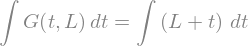




['evaluate_integrals', 2] 



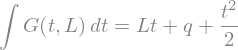

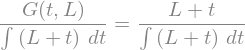

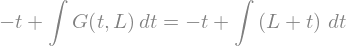

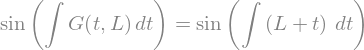

In [62]:
# check data

i = random.choice(range(len(data)))

d, negs = data[i]

for i in d:
    
    print(i[1],'\n')
    display(i[0])
    print('\n\n')
    
for i in negs:
    display(i)

In [61]:
idxs = [3]

latex_derivations = []
latex_negatives = []
srepr_derivations = []
srepr_negatives = []

loop = tqdm(range(len(data)))

for i in loop:

    derivation, negs = data[i]

    latex_derivation = []
    srepr_derivation = []

    for step in derivation:

        eq, annotation = step
        
        latex_eq = sp.latex(eq)
        srepr_eq = sp.srepr(eq)

        if type(annotation) is list:
            latex_annotation = [sp.latex(elem) if is_math(elem) else elem for elem in annotation]
            srepr_annotation = [sp.srepr(elem) if is_math(elem) else elem for elem in annotation]
            
        else:
            latex_annotation = annotation
            srepr_annotation = annotation

        latex_derivation.append((latex_annotation, latex_eq))
        srepr_derivation.append((srepr_annotation, srepr_eq))

    latex_derivations.append(latex_derivation)
    srepr_derivations.append(srepr_derivation)

    latex_negatives.append([sp.latex(neg) for neg in negs])
    srepr_negatives.append([sp.srepr(neg) for neg in negs])

  0%|          | 0/12302 [00:00<?, ?it/s]

In [63]:
def clean_derivation(d):
    
    # gets rid of unwanted text such as \\left / \\right
    
    # keeps step = (annotation, eq) format

    new_d = []

    for step in d:

        annotation, eq = step

        eq = eq.replace("\\left","").replace("\\right","").replace(' )',')')

   
        if type(annotation) is list:
            
            
            annotation = [elem.replace("\\left","").replace("\\right","").replace(' )',')') if "\\left" in str(elem) or "\\right" in str(elem) else elem for elem in annotation]


        new_d.append((annotation, eq))
        
        
    return new_d

In [64]:
all_data = []

for i in range(len(data)):
    all_data.append({'derivation':clean_derivation(latex_derivations[i]),
                      'positive_idxs':idxs,
                      'negatives':[eq.replace("\\left","").replace("\\right","").replace(' )',')') for eq in latex_negatives[i]],
                      'srepr_derivation':srepr_derivations[i],
                      'srepr_negatives':srepr_negatives[i]})

In [65]:
import json
import numpy as np

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [66]:
new_data = [i for i in all_data if not example_contains_a_func_of_a_complicated_operand(i)]
len(new_data)

In [67]:
import json
with open('next_equation_selection_steps=3.json', 'w') as f:
    json.dump(all_data, f, cls = NpEncoder)

In [55]:
import numpy as np
import json
d_file = open('next_equation_selection_steps=3.json','r')
d_json = json.load(d_file)
len(d_json)

1 
 premise




2 
 ['times', 1, exp(v**J)]




3 
 ['integrate', 2, v]


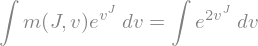

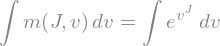

([[Eq(m(J, v), exp(v**J)), 'premise'],
  [Eq(m(J, v)*exp(v**J), exp(2*v**J)), ['times', 1, exp(v**J)]],
  [Eq(Integral(m(J, v)*exp(v**J), v), Integral(exp(2*v**J), v)),
   ['integrate', 2, v]]],
 [Eq(v**J*m(J, v), v**J*exp(v**J)),
  Eq(v**J + m(J, v)*exp(v**J), v**J + exp(2*v**J)),
  Eq(Integral(m(J, v), v), Integral(exp(v**J), v)),
  Eq(0, -m(J, v) + exp(v**J))])

In [72]:
i = random.choice(range(len(d_json)))

example = d_json[i]
get_derivation_from_example(example, True, True)

In [69]:
max(lens)

In [98]:
sum(lens)/len(lens)

In [102]:
lens = []

for i in range(len(d_json)):
    example = d_json[i]
    positive_ids = list(np.array(example["positive_idxs"]) - 1)
    candidate = [example["derivation"][equation_id][1] for equation_id in positive_ids]
    context = (str(example['derivation'][:-1]) + ' [SEP] ' + str(example['derivation'][-1][0])).replace('[[','[').replace(']]',']').replace('\\\\','\\')
    input_text = context + " [SEP] " + " ".join(candidate)
    input_text = input_text.replace("'","").replace("\\,","")
    lens.append(len(tokenizer.tokenize(input_text)))

In [107]:
input_text

'[premise, P{(H)} = \\sin{(e^{H})}], [differentiate, 1, H], \\frac{d}{d H} P{(H)} = \\frac{d}{d H} \\sin{(e^{H})}] [SEP] [evaluate_derivatives, 2] [SEP] \\frac{d}{d H} P{(H)} = e^{H} \\cos{(e^{H})}'

In [106]:
114.3*0.874

In [105]:
(sum(lens)/len(lens))/114.3

In [97]:
tokenizer.tokenize(input_text.replace("'","").replace("\\,",""))

['[',
 'premise',
 ',',
 'm',
 '{',
 '(',
 'j',
 ',',
 'v',
 ')',
 '}',
 '=',
 'e',
 '^',
 '{',
 'v',
 '^',
 '{',
 'j',
 '}',
 '}',
 ']',
 ',',
 '[',
 'times',
 ',',
 '1',
 ',',
 'e',
 '^',
 '{',
 'v',
 '^',
 '{',
 'j',
 '}',
 '}',
 ']',
 ',',
 'm',
 '{',
 '(',
 'j',
 ',',
 'v',
 ')',
 '}',
 'e',
 '^',
 '{',
 'v',
 '^',
 '{',
 'j',
 '}',
 '}',
 '=',
 'e',
 '^',
 '{',
 '2',
 'v',
 '^',
 '{',
 'j',
 '}',
 '}',
 ']',
 '[SEP]',
 '[',
 'integrate',
 ',',
 '2',
 ',',
 'v',
 ']',
 '[SEP]',
 '\\',
 'int',
 'm',
 '{',
 '(',
 'j',
 ',',
 'v',
 ')',
 '}',
 'e',
 '^',
 '{',
 'v',
 '^',
 '{',
 'j',
 '}',
 '}',
 'd',
 '##v',
 '=',
 '\\',
 'int',
 'e',
 '^',
 '{',
 '2',
 'v',
 '^',
 '{',
 'j',
 '}',
 '}',
 'd',
 '##v']

In [82]:
"integrate" in input_text.split('[SEP]')[1].split('[SEP]')[0]

True

In [60]:
from transformers import AutoTokenizer

In [61]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [63]:
len(tokenizer.tokenize(input_text))

In [124]:
def rename_derivation_variables(example, symbols, unseen_symbols):
    
    #d, negs = get_derivation_and_negative_examples(df, i)
    
    d, negs = get_derivation_from_example(example, negative_equations=True)

    new_d = []

    swaps = get_swap_list(d, symbols, unseen_symbols)
    
    #display(swaps)
    
    for i in range(len(d)):

        row = []
        for j in range(len(d[i])):

            if type(d[i][j]) is list:
                annotation = []
                for k in range(len(d[i][j])):

                    if is_math(d[i][j][k]):

                        annotation.append(rename_variables(d[i][j][k], swaps))

                    else:
                        annotation.append(d[i][j][k])

                row.append(annotation)

            elif type(d[i][j]) is sp.Equality:
                row.append(rename_variables(d[i][j], swaps))

            else:
                row.append(d[i][j])

        new_d.append(tuple(row))

    
    new_negs = [rename_variables(i, swaps) for i in negs]

    return new_d, new_negs

In [136]:
# create variable renaming data

var_data = []

loop = tqdm(d_json)
for example in loop:
    
    var_data.append(create_example(rename_derivation_variables(example, symbols, unseen_symbols),positive_idxs=[3]))

  0%|          | 0/2077 [00:00<?, ?it/s]

1 
 premise




2 
 ['integrate', 1, N]


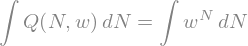



3 
 ['minus', 2, N]


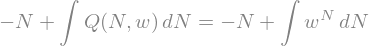

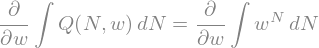

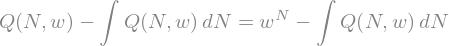

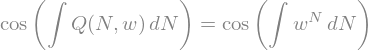

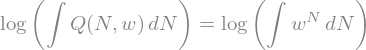

([[Eq(Q(N, w), w**N), 'premise'],
  [Eq(Integral(Q(N, w), N), Integral(w**N, N)), ['integrate', 1, N]],
  [Eq(-N + Integral(Q(N, w), N), -N + Integral(w**N, N)), ['minus', 2, N]]],
 [Eq(Derivative(Integral(Q(N, w), N), w), Derivative(Integral(w**N, N), w)),
  Eq(Q(N, w) - Integral(Q(N, w), N), w**N - Integral(Q(N, w), N)),
  Eq(cos(Integral(Q(N, w), N)), cos(Integral(w**N, N))),
  Eq(log(Integral(Q(N, w), N)), log(Integral(w**N, N)))])

In [137]:
i = random.choice(range(len(d_json)))
get_derivation_from_example(d_json[i], True, True)

1 
 premise




2 
 ['integrate', 1, \gamma]


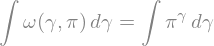



3 
 ['minus', 2, \gamma]


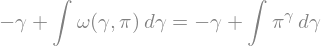

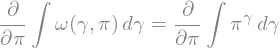

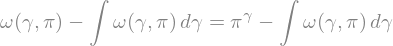

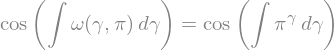

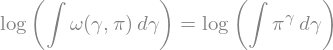

([[Eq(\omega(\gamma, \pi), \pi**\gamma), 'premise'],
  [Eq(Integral(\omega(\gamma, \pi), \gamma), Integral(\pi**\gamma, \gamma)),
   ['integrate', 1, \gamma]],
  [Eq(-\gamma + Integral(\omega(\gamma, \pi), \gamma), -\gamma + Integral(\pi**\gamma, \gamma)),
   ['minus', 2, \gamma]]],
 [Eq(Derivative(Integral(\omega(\gamma, \pi), \gamma), \pi), Derivative(Integral(\pi**\gamma, \gamma), \pi)),
  Eq(\omega(\gamma, \pi) - Integral(\omega(\gamma, \pi), \gamma), \pi**\gamma - Integral(\omega(\gamma, \pi), \gamma)),
  Eq(cos(Integral(\omega(\gamma, \pi), \gamma)), cos(Integral(\pi**\gamma, \gamma))),
  Eq(log(Integral(\omega(\gamma, \pi), \gamma)), log(Integral(\pi**\gamma, \gamma)))])

In [138]:
get_derivation_from_example(var_data[i], True, True)

In [139]:
import json
with open('EVAL_next_equation_selection_VAR_RENAMING_steps=3.json', 'w') as f:
    json.dump(var_data, f, cls = NpEncoder)

In [140]:
def expression_exchange_in_derivation(example):
    
    d, negs = get_derivation_from_example(example, negative_equations=True)

    new_d = []
    for step in d:

        eq, annotation = step

        LHS, RHS = eq.args

        new_eq = sp.Equality(RHS, LHS)

        if type(annotation) is list:
            rule = annotation[0]

            if rule == 'substitute_LHS_for_RHS':
                annotation = ['substitute_RHS_for_LHS'] + [elem for elem in annotation[1:]]

            elif rule == 'substitute_RHS_for_LHS':
                annotation = ['substitute_LHS_for_RHS'] + [elem for elem in annotation[1:]]

        new_d.append([new_eq, annotation])
        
    
    new_negs = []
    
    for neg in negs:
        
        LHS, RHS = neg.args
        new_neg = sp.Equality(RHS, LHS)
        new_negs.append(new_neg)
        
    return new_d, new_negs

In [141]:
# create exchange data

exchange_data = []

loop = tqdm(d_json)
for example in loop:
    
    exchange_data.append(create_example(expression_exchange_in_derivation(example),positive_idxs=[3]))

  0%|          | 0/2077 [00:00<?, ?it/s]

In [142]:
import json
with open('EVAL_next_equation_selection_EXPR_EXCHANGE_steps=3.json', 'w') as f:
    json.dump(exchange_data, f, cls = NpEncoder)

In [ ]:
op_swap = []

loop = tqdm(d_json)

for example in loop:
    
    d, negs = get_derivation_from_example(example, negative_equations=True)

    correct_eq = d[-1][0]

    D = d[:-1]

    target_eq = negs[0]

    while True:
        
        try:
            next_step = step(D)
        
        except FunctionTimedOut:
            pass
        
        except:
            print(d_json.index(example))
            pass

        if next_step is not False:
            if str(next_step[0]) == str(target_eq):
                #print(next_step)
                break

    negs.remove(target_eq)

    negs = [correct_eq] + negs

    derivation = [list(step) for step in D] + [list(next_step)]


    derivation_and_negs = derivation, negs

    
    op_swap.append(create_example(derivation_and_negs, positive_idxs=[3]))

  0%|          | 0/2077 [00:00<?, ?it/s]

0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
2

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
38
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
39
3

48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
48
4

53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
53
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
54
5

62
62
62
62
62
62
62
62
62
62
62
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
6

69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
7

82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
8

89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
89
8

98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
98
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
99
9

102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102
102


108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108
108


111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111


118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118


118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118
118


123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123


126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126
126


135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135
135


139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
140
140
140
140
140
140
140
140
140
140
140
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
142
142
142
142
142
142
142
142
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143


143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143
143


151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
151
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152
152


162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162
162


164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164
164


167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167
167


173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173
173


176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176
176


183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183
183


185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185
185


198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
198
199
199
199
199
199
199
199
199
199
199


202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
202
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203
203


208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
208
209
209
209
209
209
209
209
209
209
209
210
210
210
210
210
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212
212


215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215
215


220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220
220


225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
225
226
226
226
226
226


237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239
239


250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
250
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251
251


258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
258
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
259
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
260
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261
261


265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265
265


266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266
266


270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270


280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280


285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285


286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286


287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288


290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
290
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
291
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292
292


307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307
307


311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
311
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312
312


319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319


322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322
322


325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325
325


327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327
327


336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
336
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
337
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338
338


340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340
340


351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
351
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
352
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353
353


359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359
359


366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366
366


367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
367
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
368
369
369
369
369
369
369
369
369
369
369
369
369
369
369
369
369
369
369
369
369
370
370
370
370
370
370
370
370
370
370
370
370
370
370
370
370
370
370
370
371
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372
372


375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375
375


377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377


377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
377
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378
378


387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
387
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
388
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389
389


399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
400
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
401
402
402
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
403
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404


414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414
414


427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
428
428
428
428
428
428
428
428
428
428
428
428
428


432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
432
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433
433


438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438
438


444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444


444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444
444


447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447
447


449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
449
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
450
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451
451


452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452
452


456
456
456
456
456
456
456
456
456
456
456
456
456
456
456
456
456
456
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
457
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458
458


464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464
464


471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
471
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472
472


484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
484
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485
485


491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492


499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499
499


500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501


509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
509
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510
510


515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515
515


516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516


519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
519
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520
520


523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523
523


In [ ]:
import json
with open('EVAL_next_equation_selection_OP_SWAP_steps=2.json', 'w') as f:
    json.dump(op_swap, f, cls = NpEncoder)

1 
 premise




2 
 ['power', 1, y]


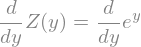

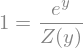

([[Eq(Z(y), exp(y)), 'premise'], [Eq(Z(y)**y, exp(y)**y), ['power', 1, y]]],
 [Eq(Derivative(Z(y), y), Derivative(exp(y), y)),
  Eq(0, -Z(y) + exp(y)),
  Eq(Z(y)**2, Z(y)*exp(y)),
  Eq(1, exp(y)/Z(y))])

In [113]:
i = random.choice(range(len(d_json)))

get_derivation_from_example(d_json[i], True, True)

1 
 premise




2 
 ['differentiate', 1, y]


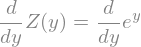

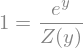

([[Eq(Z(y), exp(y)), 'premise'],
  [Eq(Derivative(Z(y), y), Derivative(exp(y), y)), ['differentiate', 1, y]]],
 [Eq(Z(y)**y, exp(y)**y),
  Eq(0, -Z(y) + exp(y)),
  Eq(Z(y)**2, Z(y)*exp(y)),
  Eq(1, exp(y)/Z(y))])

In [114]:
get_derivation_from_example(op_swap[i], True, True)